# **0 Imports**

In [177]:
import pandas as pd
import numpy as np
from IPython.display import display, Image

from scipy import stats

from matplotlib import rcParams
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.metrics import mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.tsa.vector_ar.var_model import VAR

## **0.1 Funções auxiliares**

In [80]:
def week_of_month(x):
    if x == 1:
        return 'primeira'
    elif x == 2:
        return 'segunda'
    elif x == 3:
        return 'terceira'
    elif x == 4:
        return 'quarta'
    else:
        return 'quinta'

def dia_da_semana(df, nome_coluna_data):
    nomes_dias = {
        'Monday': 'segunda',
        'Tuesday': 'terca',
        'Wednesday': 'quarta',
        'Thursday': 'quinta',
        'Friday': 'sexta',
        'Saturday': 'sabado',
        'Sunday': 'domingo'}

    df['dia_da_semana'] = df[nome_coluna_data].dt.day_name().map(nomes_dias)
    
    return df

## **0.2 Carregando os dados**

In [81]:
item_pedido=pd.read_excel('../data/ITEM_PEDIDO-_2_ _.xlsx',index_col=0)
itens=pd.read_excel('../data/ITENS-_3___.xlsx',index_col=0)
pedido=pd.read_excel('../data/PEDIDO-_1__.xlsx',index_col=0)

# **1 Descrição dos dados**

## **1.1 Tabela 'item_pedido'**

In [82]:
display(item_pedido.head())

print(item_pedido.info(),'\n')

print(f"ID's únicos \n{len(item_pedido['ID_PEDIDO'].unique())}",'\n')

quantidades = item_pedido.groupby('ID_ITEM')['QUANTIDADE'].sum().reset_index()
display(quantidades)

print('\n'"Impressões: Alguns ID'S se repetem por conterem mais de um item no pedido e não existe uma diferença discrepante entre a quantidade por item")

,ID_PEDIDO,ID_ITEM,QUANTIDADE
0,120210601,item C,4
1,220210601,item A,3
2,320210604,item C,1
3,420210604,item B,4
4,420210604,item C,2


<class 'pandas.core.frame.DataFrame'>
Index: 295 entries, 0 to 294
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID_PEDIDO   295 non-null    int64 
 1   ID_ITEM     295 non-null    object
 2   QUANTIDADE  295 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 9.2+ KB
None 

ID's únicos 
181 



,ID_ITEM,QUANTIDADE
0,item A,211
1,item B,217
2,item C,216
3,item D,251



Impressões: Alguns ID'S se repetem por conterem mais de um item no pedido e não existe uma diferença discrepante entre a quantidade por item


## **1.2 Tabela 'pedido'**

In [83]:
display(pedido.head())

print(pedido.info(),'\n')

print(f"ID's únicos \n{len(pedido['ID_PEDIDO'].unique())}",'\n')

pedido['DATA'] = pd.to_datetime(pedido['DATA'])

print(f"Data mínima {pedido['DATA'].min()} e data máxima {pedido['DATA'].max()}",'\n')

print('Impressões: O index possue ao todo 294 contagens, porém a tabela possue 181 linhas; possivelmente 113 linhas não foram imputadas por algum erro')
print('O intervalo das datas é de 3 meses')
print('A coluna VALOR_TOTAL não possue valores imputados')

,ID_PEDIDO,DATA,VALOR_TOTAL
0,120210601,2021-06-01,NaN
1,220210601,2021-06-01,NaN
2,320210604,2021-06-04,NaN
3,420210604,2021-06-04,NaN
5,520210604,2021-06-04,NaN


<class 'pandas.core.frame.DataFrame'>
Index: 181 entries, 0 to 293
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID_PEDIDO    181 non-null    int64  
 1   DATA         181 non-null    object 
 2   VALOR_TOTAL  0 non-null      float64
dtypes: float64(1), int64(1), object(1)
memory usage: 5.7+ KB
None 

ID's únicos 
181 

Data mínima 2021-06-01 00:00:00 e data máxima 2021-09-01 00:00:00 

Impressões: O index possue ao todo 294 contagens, porém a tabela possue 181 linhas; possivelmente 113 linhas não foram imputadas por algum erro
O intervalo das datas é de 3 meses
A coluna VALOR_TOTAL não possue valores imputados


## **1.3 Tabela 'itens'**

In [84]:
display(itens)

print('Impressões: Aparenta ser o tipo de entregável esperado pela empresa')

,0
item A,10
item B,15
item C,20
item D,25


Impressões: Aparenta ser o tipo de entregável esperado pela empresa


## **1.4 União dos dataframes**

In [85]:
# criando uma tabela auxiliar a partir da tabela 'item_pedido' com a coluna ID ITEM quebrada em quatro colunas para cada tipo de item
pivot_table = item_pedido.pivot_table(index='ID_PEDIDO', columns='ID_ITEM', values='QUANTIDADE', fill_value=0).reset_index()

# unindo a tabela 'pedido' com a tabela auxiliar através da coluna 'ID_PEDIDO'
pedido = pedido.merge(pivot_table[['ID_PEDIDO','item A', 'item B', 'item C', 'item D']], on='ID_PEDIDO', how='left')

# agrupando a tabela pedido pela coluna DATA a fim de ter a soma total de cada item por dia 
pedido_grouped = pedido.groupby('DATA').agg({'ID_PEDIDO': 'first',  # mantém o primeiro ID_PEDIDO
                                            'item A': 'sum',
                                            'item B': 'sum',
                                            'item C': 'sum',
                                            'item D': 'sum'}).reset_index()

# dropando coluna que não será utilizada 
pedido_grouped.drop(columns=['ID_PEDIDO'],inplace=True)
df1=pedido_grouped

## **1.5 Renomear colunas**

In [86]:
df1.rename(columns={'DATA':'data','item A':'item_a','item B':'item_b','item C':'item_c','item D':'item_d'},inplace=True)

## **1.6 Mudar tipos**

In [87]:
df1[['item_a', 'item_b', 'item_c', 'item_d']]=df1[['item_a', 'item_b', 'item_c', 'item_d']].astype(int)

## **1.7 Separação entre treino, teste e validação**

In [88]:
X = df1.drop(labels=['item_a','item_b','item_c','item_d'], axis=1)
y = df1[['item_a','item_b','item_c','item_d']]

# TimeSeriesSplit em treino, validação e teste
tscv = TimeSeriesSplit(n_splits=3)

# iterar sobre os splits
for train_index, test_index in tscv.split(X):
    
    # dividir em treino e teste
    X_train_full, X_test_full = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # dividir o treino em treino e validação (70/30)
    split_idx = int(len(X_train_full) * 0.7)
    X_train_full, X_val_full = X_train_full[:split_idx], X_train_full[split_idx:]
    y_train, y_val = y_train[:split_idx], y_train[split_idx:]

X_val_full.reset_index(drop=True,inplace=True)
X_test_full.reset_index(drop=True,inplace=True)
y_val.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

print('Training size')
print(len(X_train_full))
print(len(y_train))
print(f'Min and max training date {X_train_full["data"].min().date()} {X_train_full["data"].max().date()} \n')

print('Validation size')
print(len(X_val_full))
print(len(y_val))
print(f'Min and max validation date {X_val_full["data"].min().date()} {X_val_full["data"].max().date()} \n')

print('Test size')
print(len(X_test_full))
print(len(y_test))
print(f'Min and max test date {X_test_full["data"].min().date()} {X_test_full["data"].max().date()}')


df1 = df1[df1['data'] <= '2021-08-12']
    
# df

Training size
42
42
Min and max training date 2021-06-01 2021-07-19 

Validation size
19
19
Min and max validation date 2021-07-20 2021-08-12 

Test size
20
20
Min and max test date 2021-08-13 2021-09-01


## ***Principais ideias***

- Tabela 'item pedido':   
Contém as variáveis alvo dentro da mesma coluna   
As quantidades de cada item são aproximadas

- Tabela 'pedido':      
Contém o período total analisado (3 meses), uma coluna sem dados e índices faltantes,   
indicando um possível erro ao imputar, possivelmente ocasionando pedidos não registrados 

- Tabela 'itens':   
Entregável esperado pela empresa (previsão individual dos quatro itens)   

**Estratégia**:   
Unir as tabelas 'item pedido' e 'pedido' usando os ID's de cada pedido que são os mesmos entre as duas tabelas,   
e criando uma coluna para cada item para fazer as previsões individuais.

# **2 Feature engineering**

In [89]:
df2=df1.copy()

In [90]:
df2.head()

,data,item_a,item_b,item_c,item_d
0,2021-06-01,3,0,4,0
1,2021-06-04,0,6,3,1
2,2021-06-05,5,3,0,1
3,2021-06-06,0,8,4,0
4,2021-06-07,2,1,0,0


## **2.1 Criação de features**

In [91]:
# soma total de cada item
df2['itens_totais'] = df2[['item_a', 'item_b', 'item_c', 'item_d']].sum(axis=1)

# dia da semana
df2 = dia_da_semana(df2.loc[:, :], 'data')
X_train_full = dia_da_semana(X_train_full.loc[:, :], 'data')
X_val_full = dia_da_semana(X_val_full.loc[:, :], 'data')
X_test_full = dia_da_semana(X_test_full.loc[:, :], 'data')

# dia do mês
df2.loc[:, 'dia'] = df2['data'].dt.day

# tipo do dia
df2.loc[:, 'tipo_dia'] = df2['data'].dt.weekday.apply(lambda x: 'util' if x < 5 else 'fds')
X_train_full.loc[:, 'tipo_dia'] = X_train_full['data'].dt.weekday.apply(lambda x: 'util' if x < 5 else 'fds')
X_val_full.loc[:, 'tipo_dia'] = X_val_full['data'].dt.weekday.apply(lambda x: 'util' if x < 5 else 'fds')
X_test_full.loc[:, 'tipo_dia'] = X_test_full['data'].dt.weekday.apply(lambda x: 'util' if x < 5 else 'fds')

# semana do mês
df2.loc[:, 'semana_do_mes'] = df2['data'].dt.day.apply(lambda x: week_of_month((x - 1) // 7 + 1))
X_train_full.loc[:, 'semana_do_mes'] = X_train_full['data'].dt.day.apply(lambda x: week_of_month((x - 1) // 7 + 1))
X_val_full.loc[:, 'semana_do_mes'] = X_val_full['data'].dt.day.apply(lambda x: week_of_month((x - 1) // 7 + 1))
X_test_full.loc[:, 'semana_do_mes'] = X_test_full['data'].dt.day.apply(lambda x: week_of_month((x - 1) // 7 + 1))

# médias móveis
df2['itens_totais_mm'] = df2['itens_totais'].rolling(window=7).mean()
df2['item_a_mm'] = df2['item_a'].rolling(window=7).mean()
df2['item_b_mm'] = df2['item_b'].rolling(window=7).mean()
df2['item_c_mm'] = df2['item_c'].rolling(window=7).mean()
df2['item_d_mm'] = df2['item_d'].rolling(window=7).mean()

# <s>**3 Filtragem de variáveis**<s/>

In [92]:
df3=df2.copy()

In [93]:
df3.head(10)

,data,item_a,item_b,item_c,item_d,itens_totais,dia_da_semana,dia,tipo_dia,semana_do_mes,itens_totais_mm,item_a_mm,item_b_mm,item_c_mm,item_d_mm
0,2021-06-01,3,0,4,0,7,terca,1,util,primeira,NaN,NaN,NaN,NaN,NaN
1,2021-06-04,0,6,3,1,10,sexta,4,util,primeira,NaN,NaN,NaN,NaN,NaN
2,2021-06-05,5,3,0,1,9,sabado,5,fds,primeira,NaN,NaN,NaN,NaN,NaN
3,2021-06-06,0,8,4,0,12,domingo,6,fds,primeira,NaN,NaN,NaN,NaN,NaN
4,2021-06-07,2,1,0,0,3,segunda,7,util,primeira,NaN,NaN,NaN,NaN,NaN
5,2021-06-09,1,5,1,0,7,quarta,9,util,segunda,NaN,NaN,NaN,NaN,NaN
6,2021-06-10,0,0,4,4,8,quinta,10,util,segunda,8.000000,1.571429,3.285714,2.285714,0.857143
7,2021-06-11,0,2,0,10,12,sexta,11,util,segunda,8.714286,1.142857,3.571429,1.714286,2.285714
8,2021-06-12,1,3,0,2,6,sabado,12,fds,segunda,8.142857,1.285714,3.142857,1.285714,2.428571
9,2021-06-13,4,3,4,4,15,domingo,13,fds,segunda,9.000000,1.142857,3.142857,1.857143,2.857143


# **4 Análise exploratória dos dados**

In [141]:
df4=df3.copy()

## **4.1 Análise univariada**

### **Data**

In [142]:
print(f"Data mínima {df4['data'].min()} e máxima {df4['data'].max()}",'\n')

Data mínima 2021-06-01 00:00:00 e máxima 2021-08-12 00:00:00 



### **Itens**

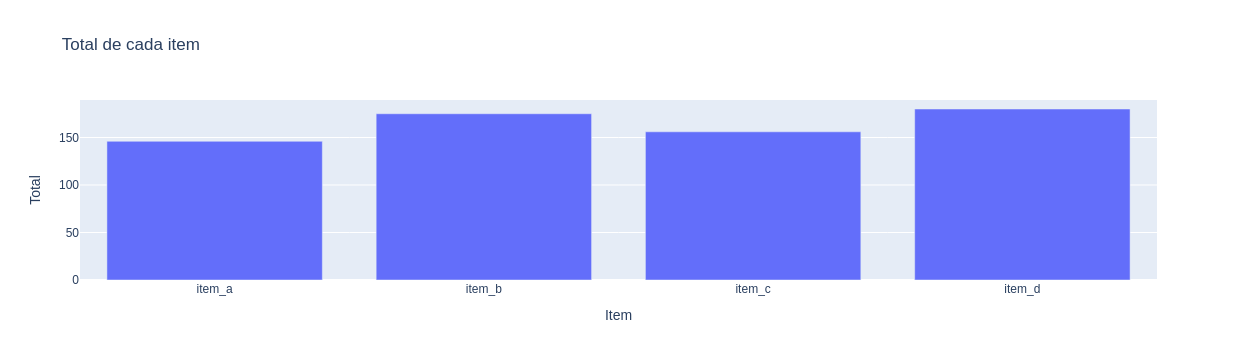

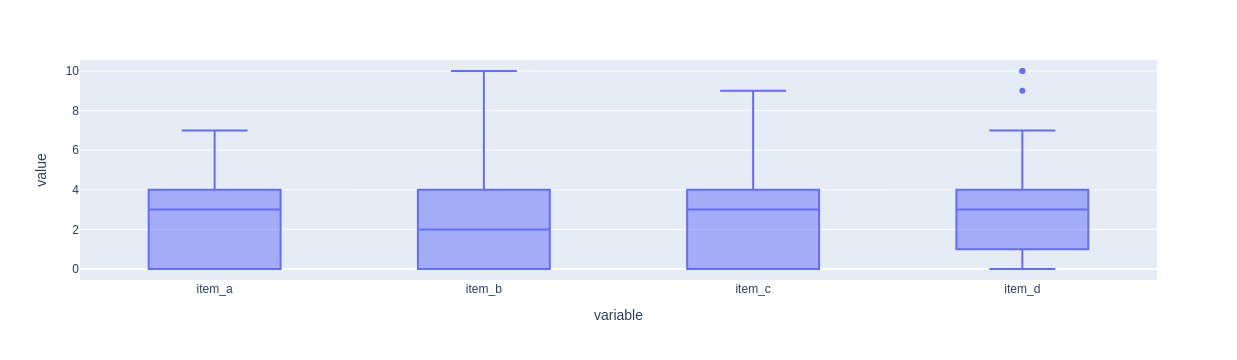

In [148]:
# Gráfico de barras
fig1 = px.bar(x=['item_a', 'item_b', 'item_c', 'item_d'],
              y=df4[['item_a', 'item_b', 'item_c', 'item_d']].sum(),
              labels={'x': 'Item', 'y': 'Total'},
              title='Total de cada item')

# Gráfico de boxplot
fig2 = px.box(df4, y=['item_a', 'item_b', 'item_c', 'item_d'])

# Exibir os gráficos
fig1.show()
fig2.show()

### **Dia da semana**

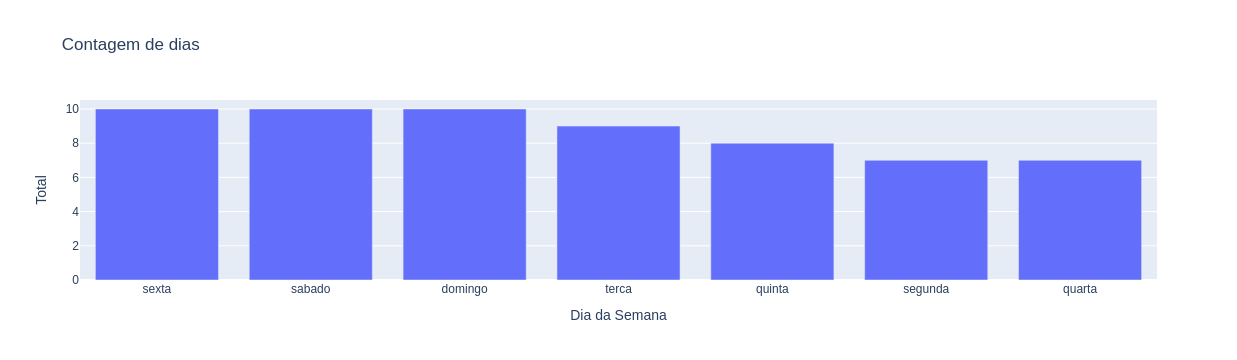

In [151]:
fig = px.bar(
    x=df4['dia_da_semana'].value_counts().index,
    y=df4['dia_da_semana'].value_counts().values,
    labels={'x': 'Dia da Semana', 'y': 'Total'},
    title='Contagem de dias'
); fig.show()

### **Dia do mês**

In [146]:
df4['dia'].value_counts()

dia
1     3
5     3
6     3
7     3
10    3
12    3
4     2
8     2
30    2
29    2
28    2
27    2
26    2
25    2
23    2
22    2
20    2
19    2
18    2
15    2
14    2
13    2
11    2
9     2
2     1
3     1
16    1
17    1
21    1
24    1
31    1
Name: count, dtype: int64

### **Semanas**

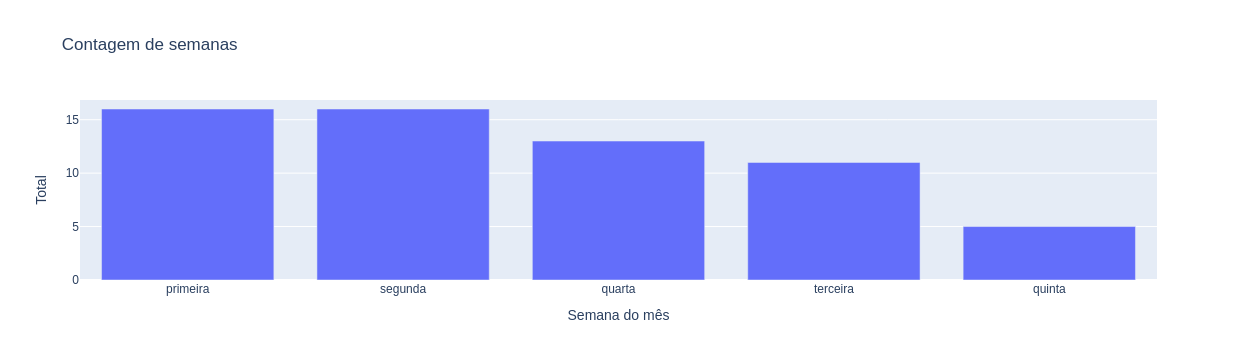

In [147]:
fig = px.bar(
    x=df4['semana_do_mes'].value_counts().index,
    y=df4['semana_do_mes'].value_counts().values,
    labels={'x': 'Semana do mês', 'y': 'Total'},
    title='Contagem de semanas'
); fig.show()

## **4.2 Análise bivariada**

### **Mindmap de hipóteses**

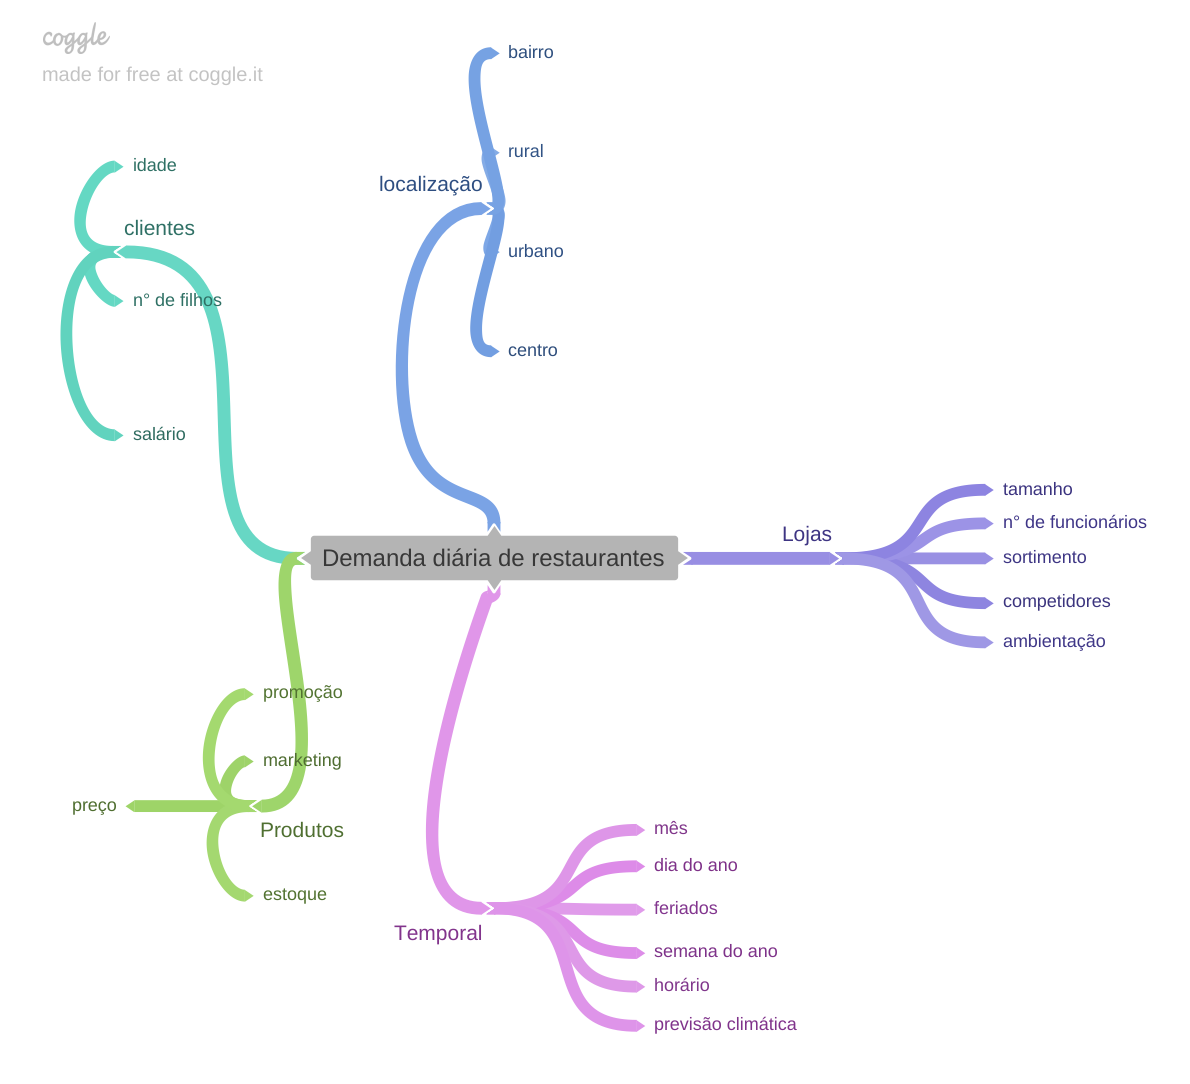

In [184]:
Image('../img/mindmap.png', width=1000, height=200)

### **Hipóteses**

#### **Segunda vende-se 20% a menos em média**

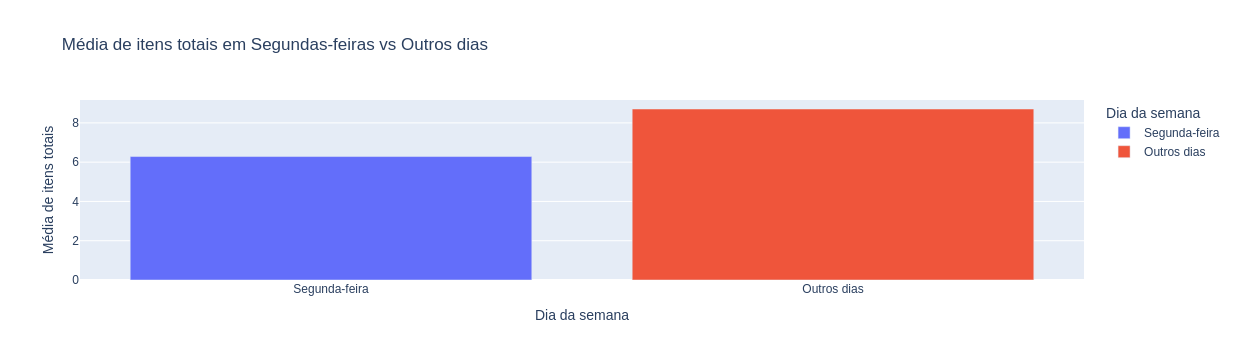


A média de itens totais é 27.81% menor em segundas-feiras em comparação com os outros dias da semana.

A diferença na média de itens totais entre segundas-feiras e outros dias da semana não é estatisticamente relevante.
Valor p: 0.07439912712282014


In [152]:
# média de itens totais para segundas
media_segunda = df4[df4['dia_da_semana'] == 'segunda']['itens_totais'].mean()

# média de itens totais para outros dias 
media_outros_dias = df4[df4['dia_da_semana'].isin(['segunda', 'terca', 'quarta', 'quinta', 'sexta'])]['itens_totais'].mean()

data = {
    'Dia da semana': ['Segunda-feira', 'Outros dias'],
    'Media de itens totais': [media_segunda, media_outros_dias]
}
df4_plot = pd.DataFrame(data)

fig = px.bar(df4_plot, x='Dia da semana', y='Media de itens totais', color='Dia da semana',
             labels={'Media de itens totais': 'Média de itens totais', 'Dia da semana': 'Dia da semana'},
             title="Média de itens totais em Segundas-feiras vs Outros dias")
fig.show()

# diff percentual
diferenca_percentual = ((media_outros_dias - media_segunda) / media_outros_dias) * 100

print('\n'f"A média de itens totais é {diferenca_percentual:.2f}% menor em segundas-feiras em comparação com os outros dias da semana."'\n')

segunda = df4[df4['dia_da_semana'] == 'segunda']['itens_totais']
outros_dias = df4[df4['dia_da_semana'].isin(['segunda', 'terca', 'quarta', 'quinta', 'sexta'])]['itens_totais']

t_statistic, p_value = stats.ttest_ind(segunda, outros_dias)

alpha = 0.05

if p_value < alpha:
    print("A diferença na média de itens totais entre segundas-feiras e outros dias da semana é estatisticamente relevante.")
else:
    print("A diferença na média de itens totais entre segundas-feiras e outros dias da semana não é estatisticamente relevante.")

print("Valor p:", p_value)

#### <u>**Sexta vende-se 40% a mais em relação a segunda a quinta**<u/>

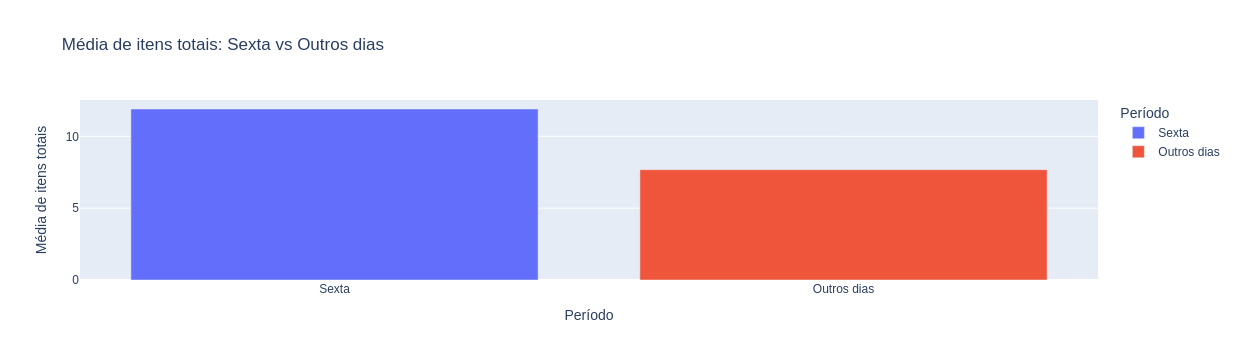


A média de itens totais na sexta-feira é 55.00% maior em comparação com os outros dias da semana.

A diferença na média de itens totais entre sexta-feira e os outros dias da semana é estatisticamente relevante.
Valor p: 0.00017583037552977237


In [153]:
# Selecionar itens totais para sexta-feira
sexta = df4[df4['dia_da_semana'] == 'sexta']['itens_totais']

# Selecionar itens totais para segunda, terça, quarta e quinta
outros_dias = df4[df4['dia_da_semana'].isin(['segunda', 'terca', 'quarta', 'quinta'])]['itens_totais']

# Calcular a média de itens totais
media_sexta = sexta.mean()
media_outros_dias = outros_dias.mean()

# Criar um DataFrame para plotagem
data = {
    'Periodo': ['Sexta', 'Outros dias'],
    'Media de itens totais': [media_sexta, media_outros_dias]
}

df4_plot = pd.DataFrame(data)

# Criar o gráfico de barras
fig = px.bar(df4_plot, x='Periodo', y='Media de itens totais', color='Periodo',
             labels={'Media de itens totais': 'Média de itens totais', 'Periodo': 'Período'},
             title="Média de itens totais: Sexta vs Outros dias")

fig.show()

# Calcular a diferença percentual
diferenca_percentual = ((media_sexta - media_outros_dias) / media_outros_dias) * 100

print('\n'f"A média de itens totais na sexta-feira é {diferenca_percentual:.2f}% maior em comparação com os outros dias da semana."'\n')

# Teste t de Student para comparar as médias
u_statistic, p_value = stats.ttest_ind(sexta, outros_dias)

alpha = 0.05

if p_value < alpha:
    print("A diferença na média de itens totais entre sexta-feira e os outros dias da semana é estatisticamente relevante.")
else:
    print("A diferença na média de itens totais entre sexta-feira e os outros dias da semana não é estatisticamente relevante.")

print("Valor p:", p_value)

#### <u>**Entre sexta a domingo, vende-se em média 60% a mais**<u/>

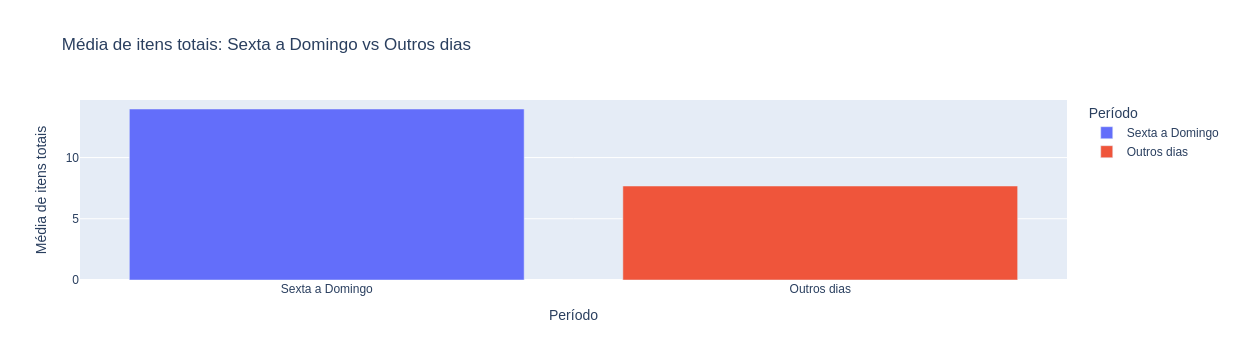


A média de itens totais de sexta a domingo é 81.92% maior em comparação com os outros dias da semana.

A diferença na média de itens totais entre sexta a domingo e os outros dias da semana é estatisticamente relevante.
Valor p: 5.716134858111313e-08


In [154]:
sexta_a_domingo = df4[df4['dia_da_semana'].isin(['sexta', 'sabado', 'domingo'])]['itens_totais']
outros_dias = df4[df4['dia_da_semana'].isin(['segunda', 'terca', 'quarta', 'quinta'])]['itens_totais']

media_sexta_a_domingo = sexta_a_domingo.mean()
media_outros_dias = outros_dias.mean()

data = {
    'Periodo': ['Sexta a Domingo', 'Outros dias'],
    'Media de itens totais': [media_sexta_a_domingo, media_outros_dias]}

df4_plot = pd.DataFrame(data)

fig = px.bar(df4_plot, x='Periodo', y='Media de itens totais', color='Periodo',
             labels={'Media de itens totais': 'Média de itens totais', 'Periodo': 'Período'},
             title="Média de itens totais: Sexta a Domingo vs Outros dias")

fig.show()

diferenca_percentual = ((media_sexta_a_domingo - media_outros_dias) / media_outros_dias) * 100

print('\n'f"A média de itens totais de sexta a domingo é {diferenca_percentual:.2f}% maior em comparação com os outros dias da semana."'\n')

u_statistic, p_value = stats.ttest_ind(sexta_a_domingo, outros_dias)

alpha = 0.05

if p_value < alpha:
    print("A diferença na média de itens totais entre sexta a domingo e os outros dias da semana é estatisticamente relevante.")
else:
    print("A diferença na média de itens totais entre sexta a domingo e os outros dias da semana não é estatisticamente relevante.")

print("Valor p:", p_value)

#### <u>**Entre sábado a domingo, vende-se em média 100% a mais**<u/>

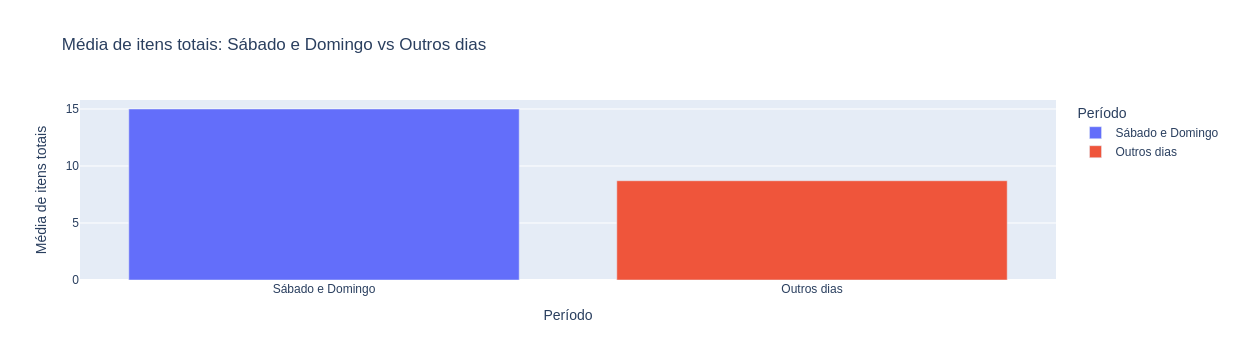


A média de itens totais de sábado e domingo é 72.27% maior em comparação com os outros dias da semana.

A diferença na média de itens totais entre sábado e domingo e os outros dias da semana é estatisticamente relevante.
Valor p: 5.364254461739674e-07


In [155]:
sabado_domingo = df4[df4['dia_da_semana'].isin(['sabado', 'domingo'])]['itens_totais']
outros_dias = df4[df4['dia_da_semana'].isin(['segunda', 'terca', 'quarta', 'quinta','sexta'])]['itens_totais']

media_sabado_domingo = sabado_domingo.mean()
media_outros_dias = outros_dias.mean()

data = {
    'Periodo': ['Sábado e Domingo', 'Outros dias'],
    'Media de itens totais': [media_sabado_domingo, media_outros_dias]}

df4_plot = pd.DataFrame(data)

fig = px.bar(df4_plot, x='Periodo', y='Media de itens totais', color='Periodo',
             labels={'Media de itens totais': 'Média de itens totais', 'Periodo': 'Período'},
             title="Média de itens totais: Sábado e Domingo vs Outros dias")

fig.show()

diferenca_percentual = ((media_sabado_domingo - media_outros_dias) / media_outros_dias) * 100

print('\n'f"A média de itens totais de sábado e domingo é {diferenca_percentual:.2f}% maior em comparação com os outros dias da semana."'\n')

u_statistic, p_value = stats.ttest_ind(sabado_domingo, outros_dias)

alpha = 0.05

if p_value < alpha:
    print("A diferença na média de itens totais entre sábado e domingo e os outros dias da semana é estatisticamente relevante.")
else:
    print("A diferença na média de itens totais entre sábado e domingo e os outros dias da semana não é estatisticamente relevante.")

print("Valor p:", p_value)


#### **Do 15° dia até o 5° dia do mês seguinte, vende-se em média 40% a mais**

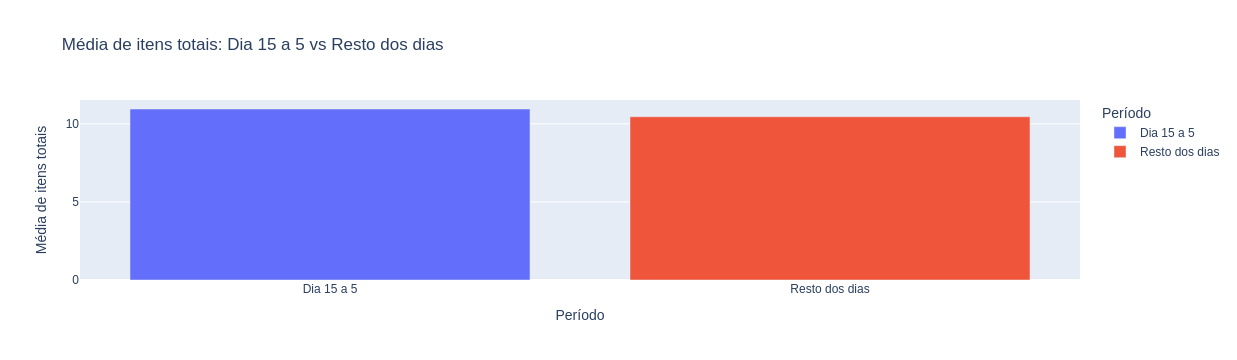


A média de itens totais do dia 15 ao dia 5 é 4.73% maior em comparação com o resto dos dias.

A diferença na média de itens totais entre os dias 15 a 5 e o resto dos dias não é estatisticamente relevante.
Valor p: 0.7164318064069204


In [156]:
periodo_15_a_5 = df4[(df4['dia'] >= 15) | (df4['dia'] <= 5)]['itens_totais']
resto_dos_dias = df4[(df4['dia'] < 15) & (df4['dia'] > 5)]['itens_totais']

media_periodo_15_a_5 = periodo_15_a_5.mean()
media_resto_dos_dias = resto_dos_dias.mean()

data = {
    'Periodo': ['Dia 15 a 5', 'Resto dos dias'],
    'Media de itens totais': [media_periodo_15_a_5, media_resto_dos_dias]
}

df4_plot = pd.DataFrame(data)

fig = px.bar(df4_plot, x='Periodo', y='Media de itens totais', color='Periodo',
             labels={'Media de itens totais': 'Média de itens totais', 'Periodo': 'Período'},
             title="Média de itens totais: Dia 15 a 5 vs Resto dos dias")

fig.show()

diferenca_percentual = ((media_periodo_15_a_5 - media_resto_dos_dias) / media_resto_dos_dias) * 100

print('\n'f"A média de itens totais do dia 15 ao dia 5 é {diferenca_percentual:.2f}% maior em comparação com o resto dos dias."'\n')

u_statistic, p_value = stats.ttest_ind(periodo_15_a_5, resto_dos_dias)

alpha = 0.05

if p_value < alpha:
    print("A diferença na média de itens totais entre os dias 15 a 5 e o resto dos dias é estatisticamente relevante.")
else:
    print("A diferença na média de itens totais entre os dias 15 a 5 e o resto dos dias não é estatisticamente relevante.")

print("Valor p:", p_value)

#### **A 1° semana e a 3° semana vendem em média 30% a mais**

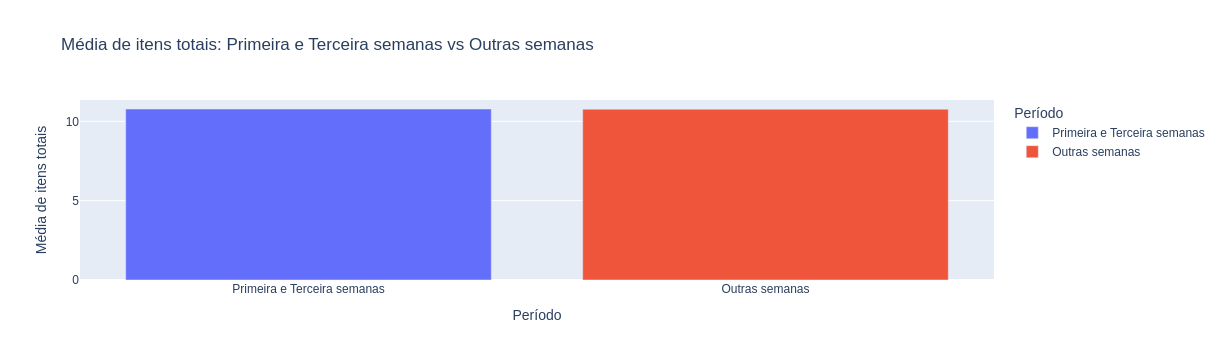


A média de itens totais nas primeiras e terceiras semanas é 0.12% maior em comparação com as outras semanas.


In [157]:
primeira_terceira_semanas = df4[df4['semana_do_mes'].isin(['primeira', 'terceira'])]['itens_totais']
outras_semanas = df4[~df4['semana_do_mes'].isin(['primeira', 'terceira'])]['itens_totais']

media_primeira_terceira = primeira_terceira_semanas.mean()
media_outras_semanas = outras_semanas.mean()

data = {
    'Periodo': ['Primeira e Terceira semanas', 'Outras semanas'],
    'Media de itens totais': [media_primeira_terceira, media_outras_semanas]}

df4_plot = pd.DataFrame(data)

fig = px.bar(df4_plot, x='Periodo', y='Media de itens totais', color='Periodo',
             labels={'Media de itens totais': 'Média de itens totais', 'Periodo': 'Período'},
             title="Média de itens totais: Primeira e Terceira semanas vs Outras semanas")

fig.show()

diferenca_percentual = ((media_primeira_terceira - media_outras_semanas) / media_outras_semanas) * 100

print('\n'f"A média de itens totais nas primeiras e terceiras semanas é {diferenca_percentual:.2f}% maior em comparação com as outras semanas.")

### **Data**

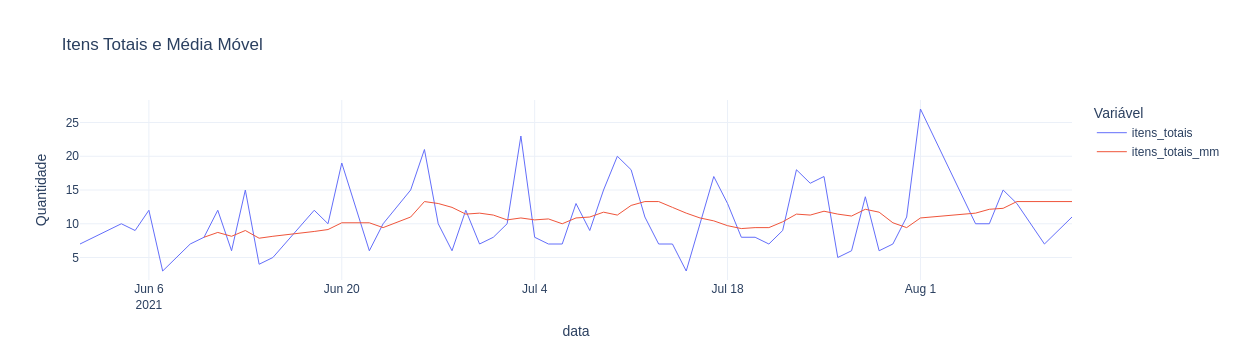

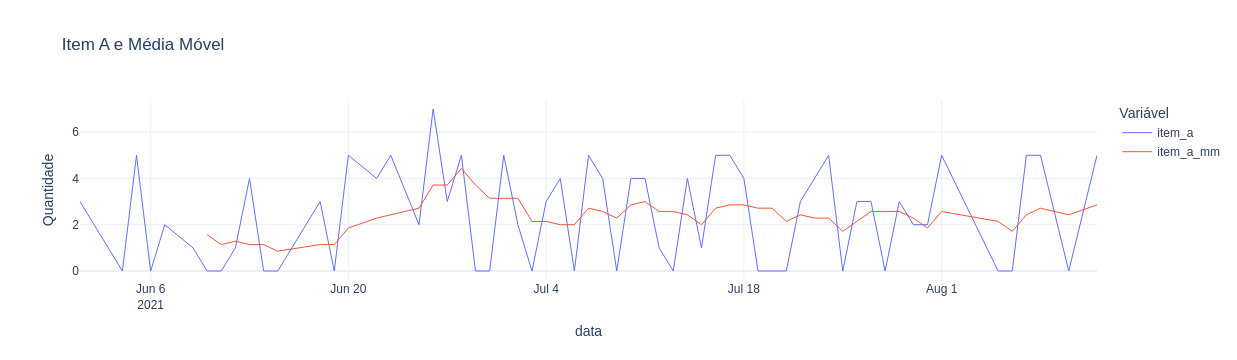

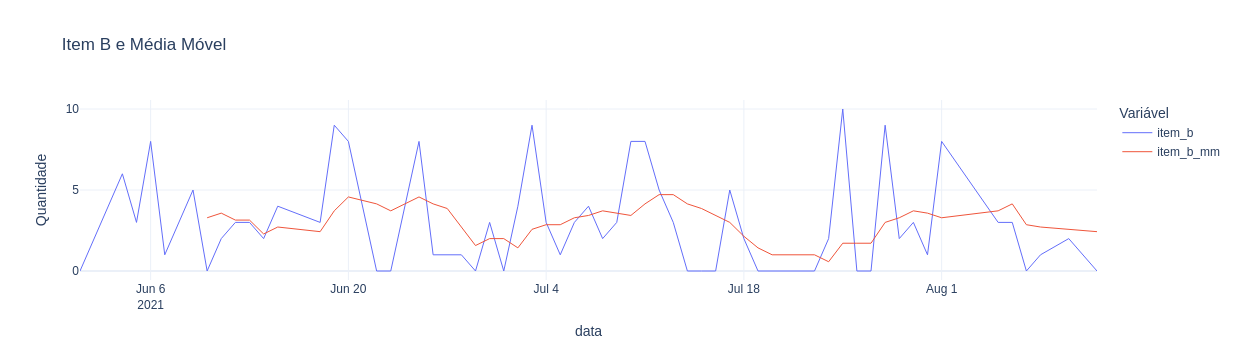

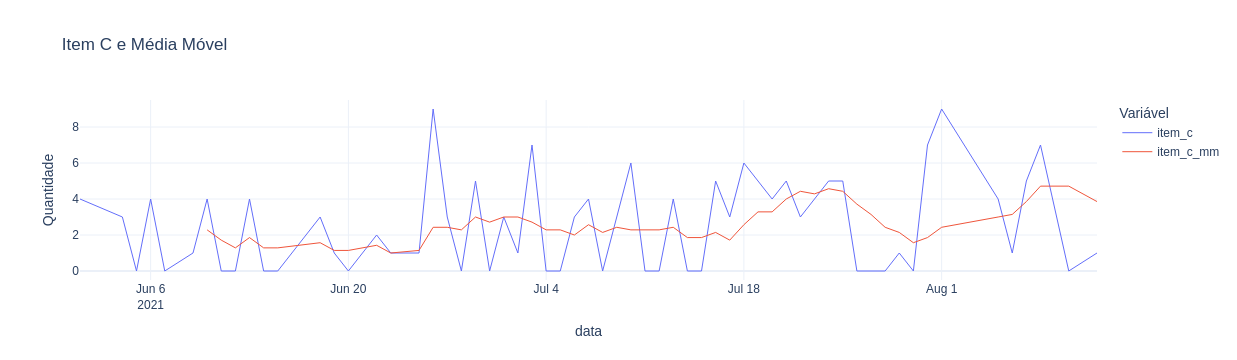

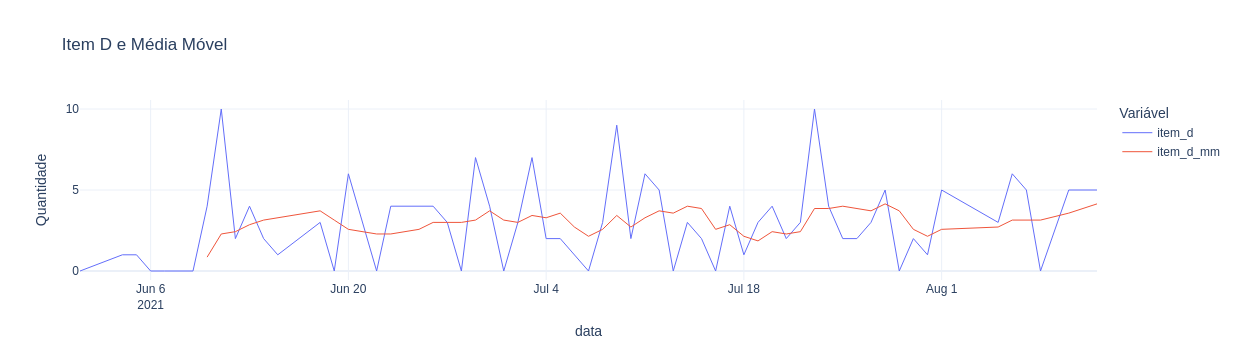

In [176]:
fig = px.line(df4, x=df4['data'], y=['itens_totais', 'itens_totais_mm'], 
              title='Itens Totais e Média Móvel',
              labels={'value': 'Quantidade', 'variable': 'Variável'},
              template='plotly_white')

fig.update_traces(line=dict(width=1))  # Ajustar a largura da linha para a média móvel

fig.show()

fig = px.line(df4, x=df4['data'], y=['item_a', 'item_a_mm'], 
              title='Item A e Média Móvel',
              labels={'value': 'Quantidade', 'variable': 'Variável'},
              template='plotly_white')

fig.update_traces(line=dict(width=1))

fig.show()

fig = px.line(df4, x=df4['data'], y=['item_b', 'item_b_mm'], 
              title='Item B e Média Móvel',
              labels={'value': 'Quantidade', 'variable': 'Variável'},
              template='plotly_white')

fig.update_traces(line=dict(width=1))

fig.show()

fig = px.line(df4, x=df4['data'], y=['item_c', 'item_c_mm'], 
              title='Item C e Média Móvel',
              labels={'value': 'Quantidade', 'variable': 'Variável'},
              template='plotly_white')

fig.update_traces(line=dict(width=1))

fig.show()

fig = px.line(df4, x=df4['data'], y=['item_d', 'item_d_mm'], 
              title='Item D e Média Móvel',
              labels={'value': 'Quantidade', 'variable': 'Variável'},
              template='plotly_white')

fig.update_traces(line=dict(width=1))

fig.show()

### **Dia da semana**

In [109]:
dias_da_semana_ordem = ['segunda', 'terca', 'quarta', 'quinta', 'sexta', 'sabado', 'domingo']
df4['dia_da_semana'] = pd.Categorical(df4['dia_da_semana'], categories=dias_da_semana_ordem, ordered=True)

# Média de itens totais por dia da semana
mean_itens_totais_por_dia = df4.groupby('dia_da_semana', observed=True)['itens_totais'].mean().reset_index()

# dados para o segundo gráfico
mean_items_por_dia = df4.groupby('dia_da_semana', observed=True)[['item_a', 'item_b', 'item_c', 'item_d']].mean().reset_index()
mean_items_por_dia_long = mean_items_por_dia.melt(id_vars='dia_da_semana', value_vars=['item_a', 'item_b', 'item_c', 'item_d'],
                                                  var_name='Item', value_name='Média')

fig1 = px.bar(mean_itens_totais_por_dia, x='dia_da_semana', y='itens_totais',
              labels={'itens_totais': 'Média de itens totais', 'dia_da_semana': 'Dia da Semana'},
              title="Média de itens totais por dia da semana")

fig2 = px.bar(mean_items_por_dia_long, x='dia_da_semana', y='Média', color='Item', barmode='group',
              labels={'Média': 'Média dos Itens', 'dia_da_semana': 'Dia da Semana'},
              title="Média de Itens por Dia da Semana")

fig = make_subplots(rows=2, cols=1, subplot_titles=("Média de itens totais por dia da semana", "Média de Itens por Dia da Semana"))

# adicionar os gráficos aos subplots
fig.add_trace(fig1['data'][0], row=1, col=1)
fig.add_traces(fig2['data'], rows=[2]*len(fig2['data']), cols=[1]*len(fig2['data']))

fig.update_layout(height=800, width=1200, showlegend=True, title_text="Análise de Itens por Dia da Semana")

fig.update_xaxes(title_text="Dia da Semana", row=1, col=1)
fig.update_yaxes(title_text="Média de itens totais", row=1, col=1)
fig.update_xaxes(title_text="Dia da Semana", row=2, col=1)
fig.update_yaxes(title_text="Média dos Itens", row=2, col=1)

fig.show()

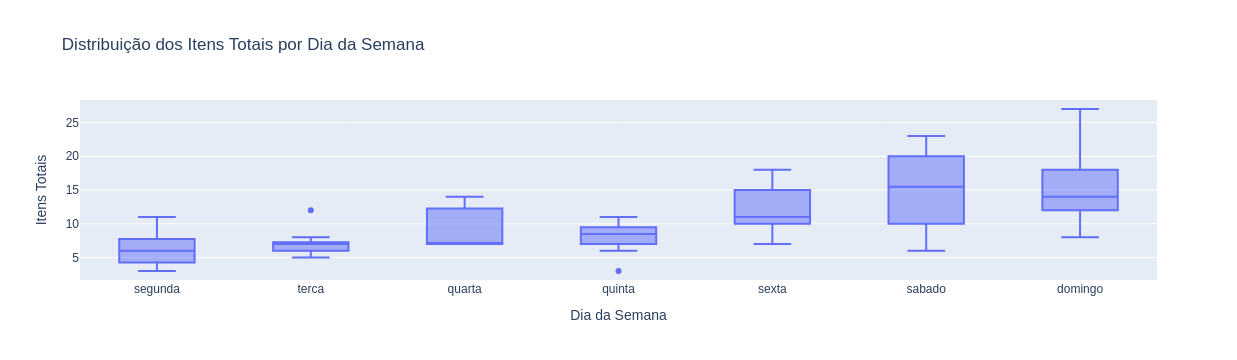

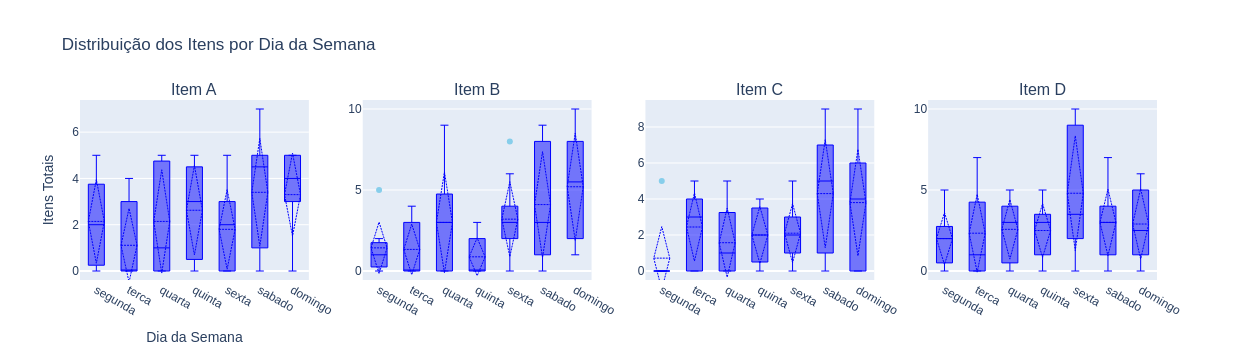

In [160]:
dias_ordenados = ['segunda', 'terca', 'quarta', 'quinta', 'sexta', 'sabado', 'domingo']
df4['dia_da_semana'] = pd.Categorical(df4['dia_da_semana'], categories=dias_ordenados, ordered=True)

fig1 = px.box(df4, x='dia_da_semana', y='itens_totais', 
             labels={'itens_totais': 'Itens Totais', 'dia_da_semana': 'Dia da Semana'},
             title='Distribuição dos Itens Totais por Dia da Semana',
             category_orders={"dia_da_semana": dias_ordenados})

# criar os boxplots individuais para cada item
fig2 = make_subplots(rows=1, cols=4, subplot_titles=('Item A', 'Item B', 'Item C', 'Item D'))

for i, item in enumerate(['item_a', 'item_b', 'item_c', 'item_d']):
    box = go.Box(
        y=df4[item],
        x=df4['dia_da_semana'],
        name=item.upper(),
        boxmean='sd',
        marker=dict(color='skyblue'),
        line=dict(color='blue', width=1)
    )
    fig2.add_trace(box, row=1, col=i+1)

fig2.update_layout(title='Distribuição dos Itens por Dia da Semana',
                  yaxis_title='Itens Totais',
                  xaxis_title='Dia da Semana')

# definir a ordem dos dias da semana
fig2.update_xaxes(categoryorder='array', categoryarray=dias_ordenados)
fig2.update_traces(showlegend=False)

fig1.show()
fig2.show()

### **Dia do mês**

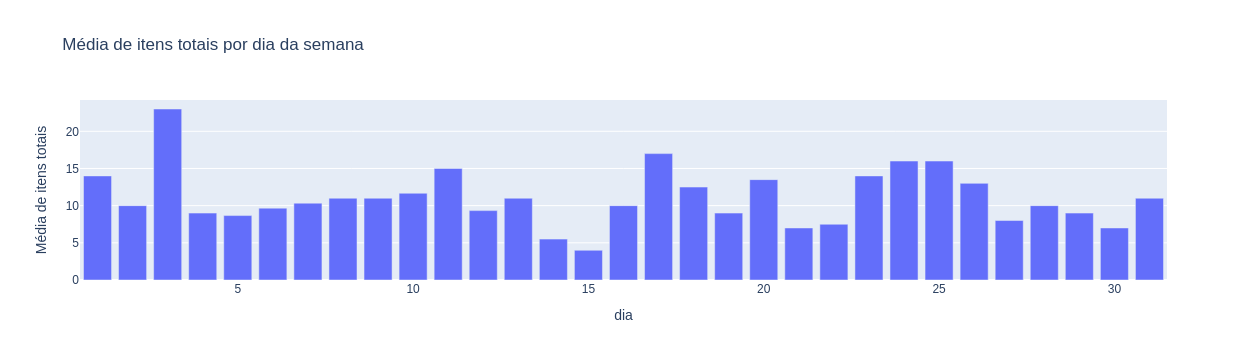

In [111]:
mean_itens_totais_por_dia = df4.groupby('dia', observed=True)['itens_totais'].mean().reset_index()

fig = px.bar(mean_itens_totais_por_dia, x='dia', y='itens_totais', 
             labels={'itens_totais': 'Média de itens totais', 'dia_da_semana': 'Dia da semana'},
             title="Média de itens totais por dia da semana")

fig.show()

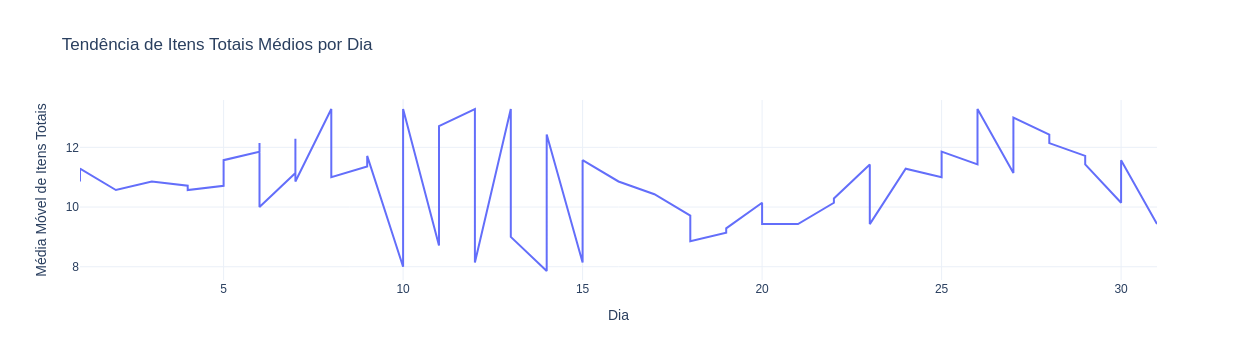

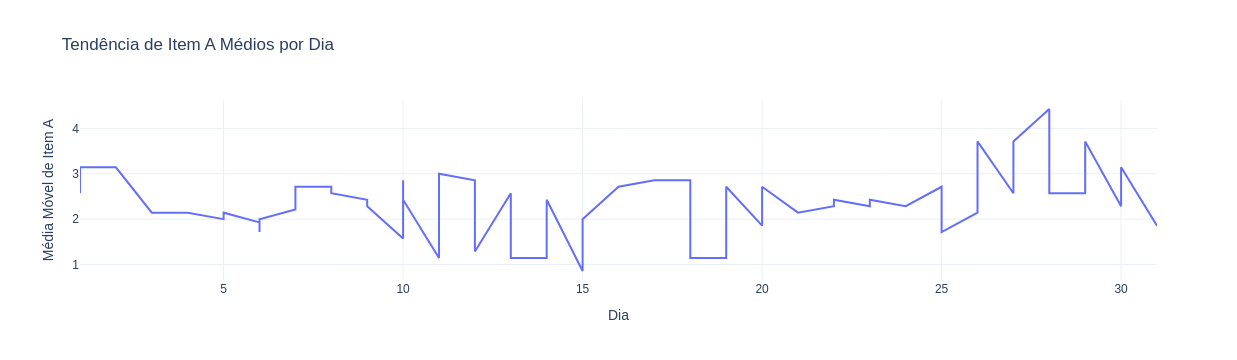

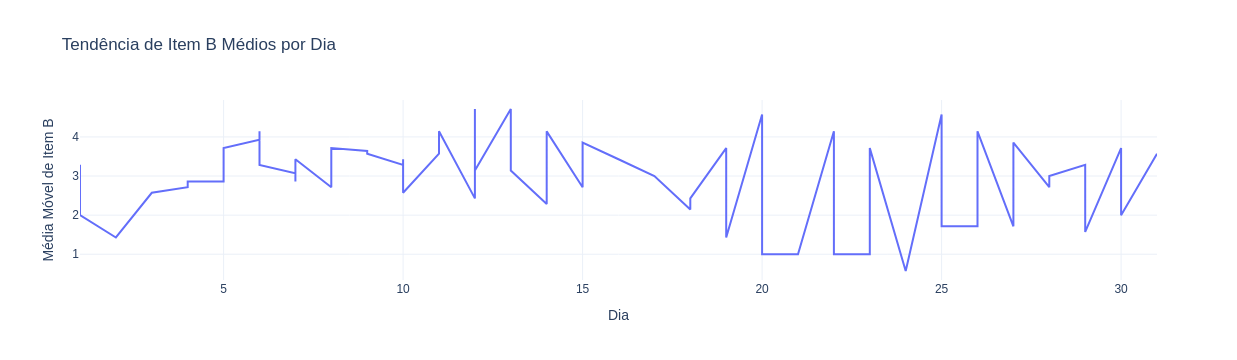

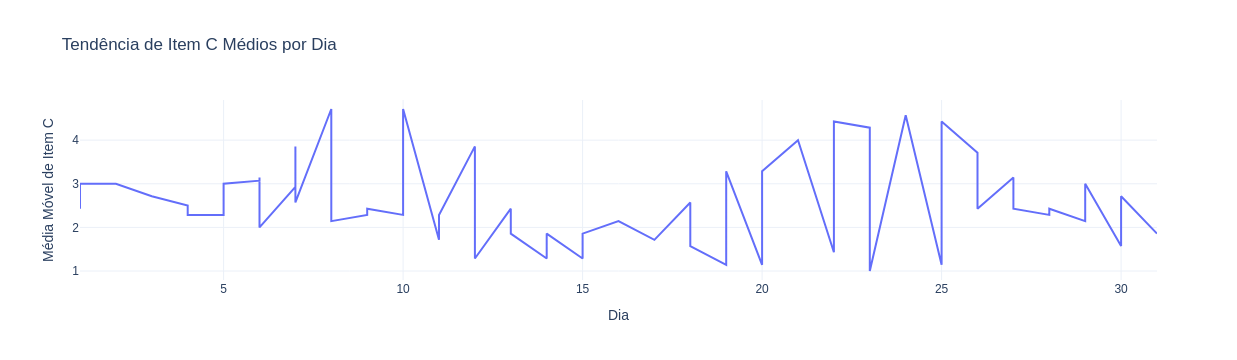

In [161]:
aux = df4.sort_values('dia').copy()

# Interpolar valores ausentes em 'itens_totais_mm'
aux['itens_totais_mm'] = aux['itens_totais_mm'].interpolate()

# Interpolar valores ausentes em 'item_a_mm'
aux['item_a_mm'] = aux['item_a_mm'].interpolate()

# Interpolar valores ausentes em 'item_b_mm'
aux['item_b_mm'] = aux['item_b_mm'].interpolate()

# Interpolar valores ausentes em 'item_c_mm'
aux['item_c_mm'] = aux['item_c_mm'].interpolate()

fig1 = px.line(aux, x='dia', y='itens_totais_mm', title='Tendência de Itens Totais Médios por Dia')
fig1.update_layout(xaxis_title='Dia', yaxis_title='Média Móvel de Itens Totais', template='plotly_white')

fig2 = px.line(aux, x='dia', y='item_a_mm', title='Tendência de Item A Médios por Dia')
fig2.update_layout(xaxis_title='Dia', yaxis_title='Média Móvel de Item A', template='plotly_white')

fig3 = px.line(aux, x='dia', y='item_b_mm', title='Tendência de Item B Médios por Dia')
fig3.update_layout(xaxis_title='Dia', yaxis_title='Média Móvel de Item B', template='plotly_white')

fig4 = px.line(aux, x='dia', y='item_c_mm', title='Tendência de Item C Médios por Dia')
fig4.update_layout(xaxis_title='Dia', yaxis_title='Média Móvel de Item C', template='plotly_white')

fig1.show()
fig2.show()
fig3.show()
fig4.show()

In [113]:
df4[df4['dia']==15]

,data,item_a,item_b,item_c,item_d,itens_totais,dia_da_semana,dia,tipo_dia,semana_do_mes,itens_totais_mm,item_a_mm,item_b_mm,item_c_mm,item_d_mm
11,2021-06-15,0,4,0,1,5,terca,15,util,terceira,8.142857,0.857143,2.714286,1.285714,3.285714
37,2021-07-15,1,0,0,2,3,quinta,15,util,terceira,11.571429,2.000000,3.857143,1.857143,3.857143


### **Semana do mês**

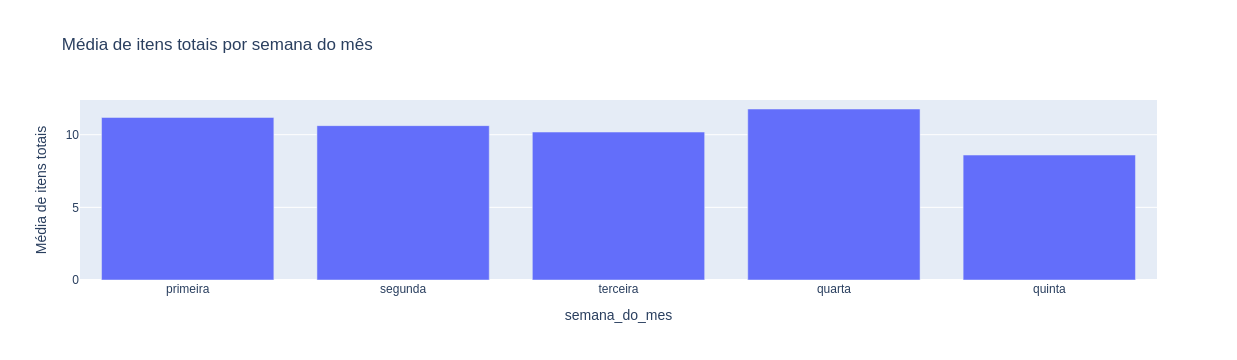

In [162]:
# ordem dos dias da semana
semana_do_mes_ordem = ['primeira','segunda', 'terceira', 'quarta', 'quinta']
df4['semana_do_mes'] = pd.Categorical(df4['semana_do_mes'], categories=semana_do_mes_ordem, ordered=True)

mean_itens_totais_por_dia = df4.groupby('semana_do_mes', observed=True)['itens_totais'].mean().reset_index()

fig = px.bar(mean_itens_totais_por_dia, x='semana_do_mes', y='itens_totais', 
             labels={'itens_totais': 'Média de itens totais'},
             title="Média de itens totais por semana do mês")

fig.show()

In [115]:
# Definir a ordem das semanas do mês
semana_do_mes_ordem = ['primeira', 'segunda', 'terceira', 'quarta', 'quinta']
df4['semana_do_mes'] = pd.Categorical(df4['semana_do_mes'], categories=semana_do_mes_ordem, ordered=True)

itens = ['item_a', 'item_b', 'item_c', 'item_d']

fig = make_subplots(rows=2, cols=2, subplot_titles=itens)

# Iterar sobre cada item e adicionar ao subplot
for i, item in enumerate(itens):
    row = (i // 2) + 1
    col = (i % 2) + 1
    
    fig.add_trace(
        go.Box(x=df4['semana_do_mes'], y=df4[item], name=item),
        row=row, col=col
    )

fig.update_layout(height=500, width=1200, title_text="Distribuição dos Itens por Semana do Mês")

fig.show()

### **Novas hipóteses**

#### **A primeira e a quarta semana do mês vendem 40% mais que as outras**

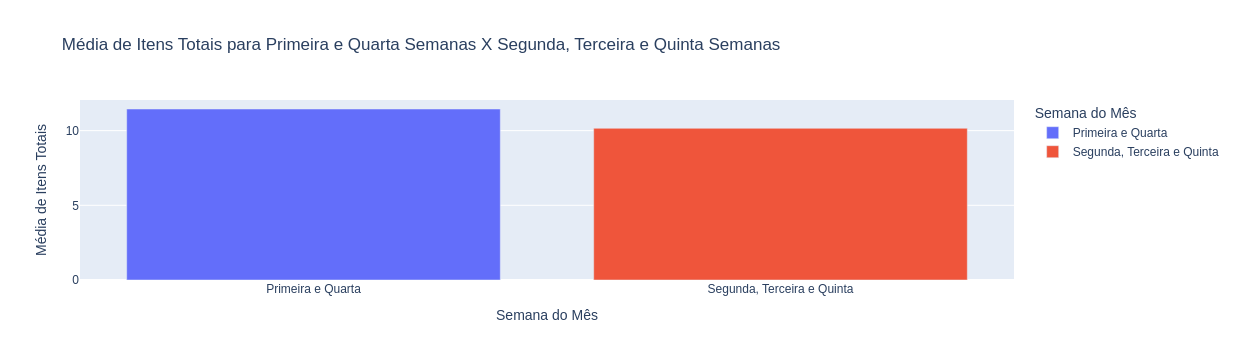


A média de itens totais é 12.72% maior nas primeiras e quartas semanas em comparação com as segundas, terceiras e quintas semanas.
A diferença na média não é estatisticamente relevante.
Valor p: 0.3215613358348667


In [163]:
media_primeira_quarta = df4[df4['semana_do_mes'].isin(['primeira', 'quarta'])]['itens_totais'].mean()

media_segunda_terceira_quinta = df4[df4['semana_do_mes'].isin(['segunda', 'terceira', 'quinta'])]['itens_totais'].mean()

data = {
    'Semana do Mês': ['Primeira e Quarta', 'Segunda, Terceira e Quinta'],
    'Média de Itens Totais': [media_primeira_quarta, media_segunda_terceira_quinta]
}
df_plot = pd.DataFrame(data)

fig = px.bar(df_plot, x='Semana do Mês', y='Média de Itens Totais', color='Semana do Mês',
             labels={'Média de Itens Totais': 'Média de Itens Totais', 'Semana do Mês': 'Semana do Mês'},
             title="Média de Itens Totais para Primeira e Quarta Semanas X Segunda, Terceira e Quinta Semanas")

fig.show()

diferenca_percentual = ((media_primeira_quarta - media_segunda_terceira_quinta) / media_segunda_terceira_quinta) * 100

print(f"\nA média de itens totais é {abs(diferenca_percentual):.2f}% maior nas primeiras e quartas semanas em comparação com as segundas, terceiras e quintas semanas.")

primeira_quarta = df4[df4['semana_do_mes'].isin(['primeira', 'quarta'])]['itens_totais']
segunda_terceira_quinta = df4[df4['semana_do_mes'].isin(['segunda', 'terceira', 'quinta'])]['itens_totais']

t_statistic, p_value = stats.ttest_ind(primeira_quarta, segunda_terceira_quinta)

alpha = 0.05

if p_value < alpha:
    print("A diferença na média de itens totais entre primeiras e quartas semanas e segundas, terceiras e quintas semanas é estatisticamente relevante.")
else:
    print("A diferença na média não é estatisticamente relevante.")

# Imprimindo o valor p
print("Valor p:", p_value)

#### **Às quartas, a média de venda total é 50% maior em relação às segundas, terças e quintas**

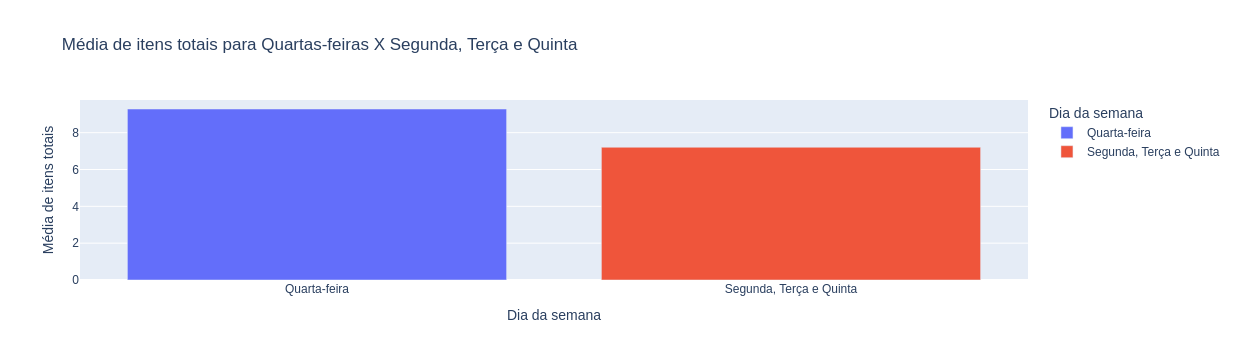


A média de itens totais é 28.82% maior em quartas-feiras em comparação com segundas, terças e quintas-feiras.
A diferença na média não é estatisticamente relevante.
Valor p: 0.06708141192485523


In [164]:
# Média de itens totais para quartas-feiras
media_quarta = df4[df4['dia_da_semana'] == 'quarta']['itens_totais'].mean()

# Média de itens totais para segundas, terças e quintas-feiras (outros dias)
media_segunda_terca_quinta = df4[df4['dia_da_semana'].isin(['segunda', 'terca', 'quinta'])]['itens_totais'].mean()

# Criar um DataFrame para o plot
data = {
    'Dia da semana': ['Quarta-feira', 'Segunda, Terça e Quinta'],
    'Media de itens totais': [media_quarta, media_segunda_terca_quinta]
}
df_plot = pd.DataFrame(data)

# Plotar o gráfico de barras
fig = px.bar(df_plot, x='Dia da semana', y='Media de itens totais', color='Dia da semana',
             labels={'Media de itens totais': 'Média de itens totais', 'Dia da semana': 'Dia da semana'},
             title="Média de itens totais para Quartas-feiras X Segunda, Terça e Quinta")

fig.show()

# Cálculo da diferença percentual
diferenca_percentual = ((media_quarta - media_segunda_terca_quinta) / media_segunda_terca_quinta) * 100

# Imprimindo a diferença percentual
print(f"\nA média de itens totais é {abs(diferenca_percentual):.2f}% maior em quartas-feiras em comparação com segundas, terças e quintas-feiras.")

# Realizando o teste t
quarta = df4[df4['dia_da_semana'] == 'quarta']['itens_totais']
segunda_terca_quinta = df4[df4['dia_da_semana'].isin(['segunda', 'terca', 'quinta'])]['itens_totais']

t_statistic, p_value = stats.ttest_ind(quarta, segunda_terca_quinta)

alpha = 0.05

# Verificando a significância estatística
if p_value < alpha:
    print("A diferença na média de itens totais entre quartas-feiras e segundas, terças e quintas-feiras é estatisticamente relevante.")
else:
    print("A diferença na média não é estatisticamente relevante.")

# Imprimindo o valor p
print("Valor p:", p_value)

#### **Entre segunda a quinta, o item c vende 20% a menos às segundas**

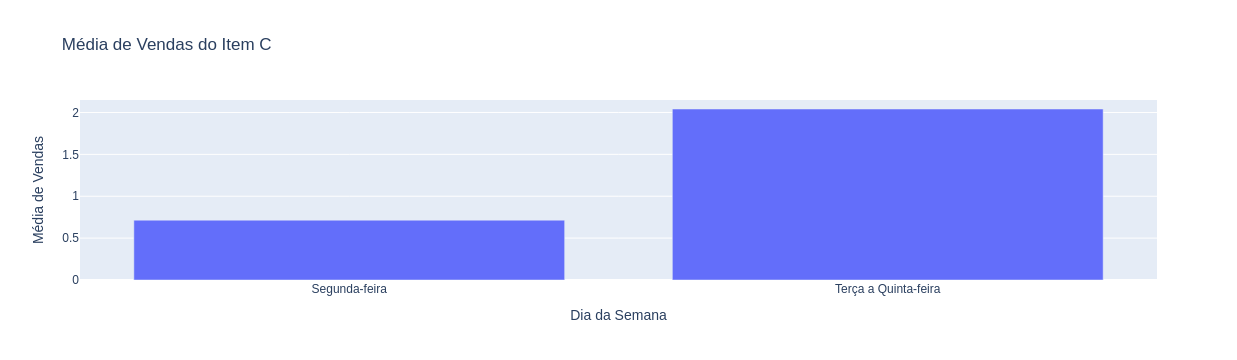


A média de vendas do Item C é -65.01% menor nas segundas-feiras em comparação com os outros dias da semana.

A diferença na média de vendas do item C entre segundas-feiras e terça a quinta-feira não é estatisticamente relevante.
Valor p: 0.083029343109574


In [165]:
# Média de vendas do item C às segundas-feiras
media_segunda_item_c = df4[df4['dia_da_semana'] == 'segunda']['item_c'].mean()

# Média de vendas do item C entre terça e sexta-feira
media_terca_sexta_item_c = (df4[(df4['dia_da_semana'] != 'segunda') & (df4['dia_da_semana'] != 'sexta') & (df4['dia_da_semana'] != 'sabado') & 
                            (df4['dia_da_semana'] != 'domingo')]['item_c'].mean())

# Criação do DataFrame para o gráfico de barras
data = {
    'Dia da Semana': ['Segunda-feira', 'Terça a Quinta-feira'],
    'Média de Vendas do Item C': [media_segunda_item_c, media_terca_sexta_item_c]
}
df_bar = pd.DataFrame(data)

# Plot do gráfico de barras
fig_bar = px.bar(df_bar, x='Dia da Semana', y='Média de Vendas do Item C', 
                 labels={'Média de Vendas do Item C': 'Média de Vendas', 'Dia da Semana': 'Dia da Semana'},
                 title='Média de Vendas do Item C')

# Exibir o gráfico de barras
fig_bar.show()

segunda_item_c = df4[df4['dia_da_semana'] == 'segunda']['item_c']
outros_dias_item_c = df4[(df4['dia_da_semana'] != 'segunda') & 
                         (df4['dia_da_semana'] != 'sabado') & 
                         (df4['dia_da_semana'] != 'domingo')]['item_c']

# Cálculo da diferença percentual
diferenca_percentual = ((media_segunda_item_c - media_terca_sexta_item_c) / media_terca_sexta_item_c) * 100

# Imprimindo a diferença percentual
print('\n'f"A média de vendas do Item C é {diferenca_percentual:.2f}% menor nas segundas-feiras em comparação com os outros dias da semana."'\n')

# Realizando o teste t
t_statistic, p_value = stats.ttest_ind(segunda_item_c, outros_dias_item_c)

alpha = 0.05

if p_value < alpha:
    print("A diferença na média de vendas do item C entre segundas-feiras e terça a quinta-feira é estatisticamente relevante.")
else:
    print("A diferença na média de vendas do item C entre segundas-feiras e terça a quinta-feira não é estatisticamente relevante.")

print("Valor p:", p_value)

#### **Às quartas, o item c vende 30% menos do que os outros itens**

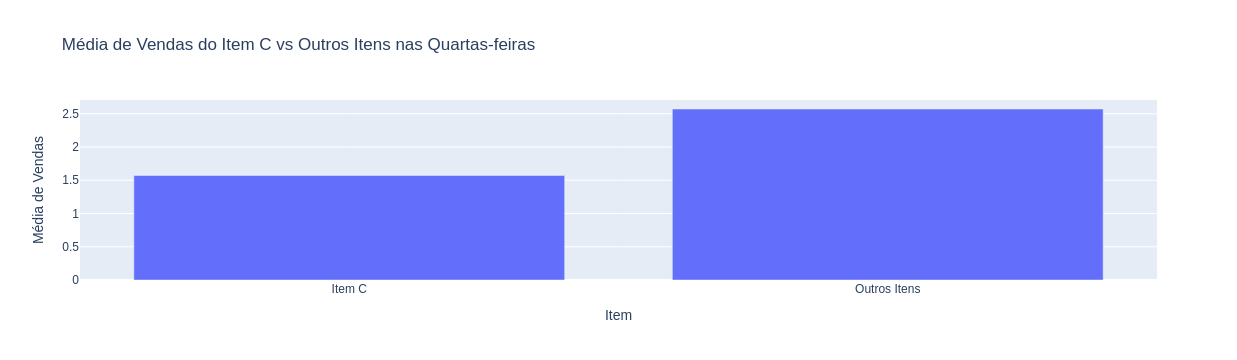


A média de vendas do Item C é 38.89% menor nas quartas-feiras em comparação com os outros itens.

A diferença na média de vendas do Item C nas quartas-feiras em comparação com os outros itens nas quartas-feiras não é estatisticamente relevante.
Valor p: 0.356443531289529


In [166]:
# Média de vendas do Item C nas quartas-feiras
media_quarta_item_c = df4[df4['dia_da_semana'] == 'quarta']['item_c'].mean()

# Média de vendas dos outros itens nas quartas-feiras
media_quarta_outros_itens = df4[df4['dia_da_semana'] == 'quarta'][['item_a', 'item_b', 'item_d']].mean().mean()

# Criação do DataFrame para o gráfico de barras
data = {
    'Item': ['Item C', 'Outros Itens'],
    'Média de Vendas': [media_quarta_item_c, media_quarta_outros_itens]
}
df_bar = pd.DataFrame(data)

# Plot do gráfico de barras
fig_bar = px.bar(df_bar, x='Item', y='Média de Vendas', 
                 labels={'Média de Vendas': 'Média de Vendas', 'Item': 'Item'},
                 title='Média de Vendas do Item C vs Outros Itens nas Quartas-feiras')

# Exibir o gráfico de barras
fig_bar.show()

# Cálculo da diferença percentual
diferenca_percentual = ((media_quarta_outros_itens - media_quarta_item_c) / media_quarta_outros_itens) * 100

# Imprimindo a diferença percentual
print('\n'f"A média de vendas do Item C é {diferenca_percentual:.2f}% menor nas quartas-feiras em comparação com os outros itens."'\n')

# Realizando o teste t
quarta_item_c = df4[df4['dia_da_semana'] == 'quarta']['item_c']
quarta_outros_itens = df4[df4['dia_da_semana'] == 'quarta'][['item_a', 'item_b', 'item_d']].values.flatten()

t_statistic, p_value = stats.ttest_ind(quarta_item_c, quarta_outros_itens)

alpha = 0.05

if p_value < alpha:
    print("A diferença na média de vendas do Item C nas quartas-feiras em comparação com os outros itens nas quartas-feiras é estatisticamente relevante.")
else:
    print("A diferença na média de vendas do Item C nas quartas-feiras em comparação com os outros itens nas quartas-feiras não é estatisticamente relevante.")

print("Valor p:", p_value)


#### <u>**Às quintas, o item b vende 30% menos do que os outros itens**<u/>

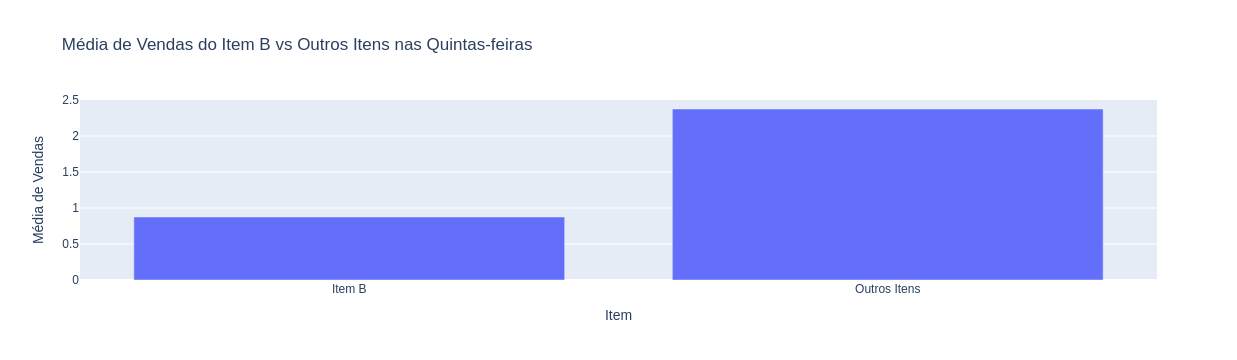


A média de vendas do Item B é 63.16% menor nas quintas-feiras em comparação com os outros itens.

A diferença na média de vendas do Item B nas quintas-feiras em comparação com os outros itens nas quintas-feiras é estatisticamente relevante.
Valor p: 0.03649311160948566


In [167]:
# Média de vendas do Item B nas quintas-feiras
media_quinta_item_b = df4[df4['dia_da_semana'] == 'quinta']['item_b'].mean()

# Média de vendas dos outros itens nas quintas-feiras
media_quinta_outros_itens = df4[df4['dia_da_semana'] == 'quinta'][['item_a', 'item_c', 'item_d']].mean().mean()

# Criação do DataFrame para o gráfico de barras
data = {
    'Item': ['Item B', 'Outros Itens'],
    'Média de Vendas': [media_quinta_item_b, media_quinta_outros_itens]
}
df_bar = pd.DataFrame(data)

# Plot do gráfico de barras
fig_bar = px.bar(df_bar, x='Item', y='Média de Vendas', 
                 labels={'Média de Vendas': 'Média de Vendas', 'Item': 'Item'},
                 title='Média de Vendas do Item B vs Outros Itens nas Quintas-feiras')

# Exibir o gráfico de barras
fig_bar.show()

# Cálculo da diferença percentual
diferenca_percentual = ((media_quinta_outros_itens - media_quinta_item_b) / media_quinta_outros_itens) * 100

# Imprimindo a diferença percentual
print('\n'f"A média de vendas do Item B é {diferenca_percentual:.2f}% menor nas quintas-feiras em comparação com os outros itens."'\n')

# Realizando o teste t
quinta_item_b = df4[df4['dia_da_semana'] == 'quinta']['item_b']
quinta_outros_itens = df4[df4['dia_da_semana'] == 'quinta'][['item_a', 'item_c', 'item_d']].values.flatten()

t_statistic, p_value = stats.ttest_ind(quinta_item_b, quinta_outros_itens)

alpha = 0.05

if p_value < alpha:
    print("A diferença na média de vendas do Item B nas quintas-feiras em comparação com os outros itens nas quintas-feiras é estatisticamente relevante.")
else:
    print("A diferença na média de vendas do Item B nas quintas-feiras em comparação com os outros itens nas quintas-feiras não é estatisticamente relevante.")

print("Valor p:", p_value)

#### **Aos domingos, o item b vende 40% a mais do que os outros itens**

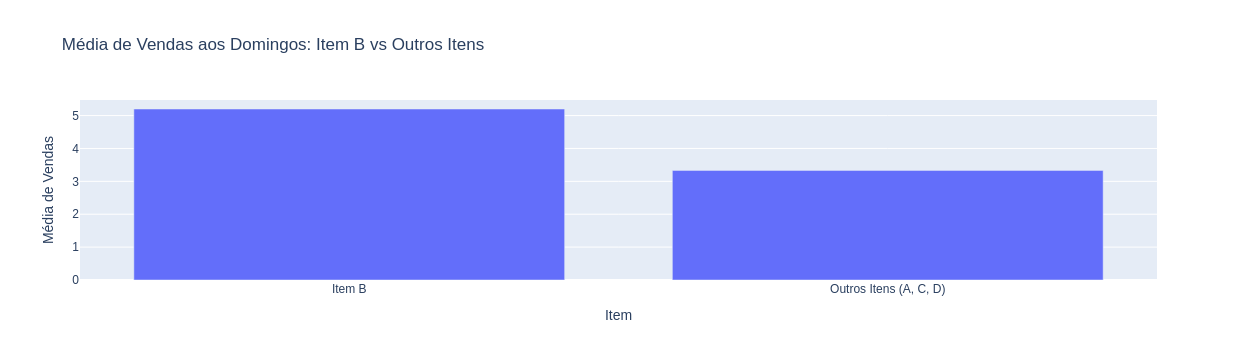


A média de vendas do Item B é 56.00% maior aos domingos em comparação com os outros itens.

A diferença na média de vendas do Item B aos domingos em comparação com os outros itens não é estatisticamente relevante.
Valor p: 0.06746071758853335


In [168]:
# Média de vendas do Item B aos domingos
media_domingo_item_b = df4[df4['dia_da_semana'] == 'domingo']['item_b'].mean()

# Média de vendas dos outros itens (A, C, D) aos domingos
media_domingo_outros_itens = df4[df4['dia_da_semana'] == 'domingo'][['item_a', 'item_c', 'item_d']].mean().mean()

# Criação do DataFrame para o gráfico de barras
data = {
    'Item': ['Item B', 'Outros Itens (A, C, D)'],
    'Média de Vendas aos Domingos': [media_domingo_item_b, media_domingo_outros_itens]
}
df_bar = pd.DataFrame(data)

# Plot do gráfico de barras
fig_bar = px.bar(df_bar, x='Item', y='Média de Vendas aos Domingos', 
                 labels={'Média de Vendas aos Domingos': 'Média de Vendas', 'Item': 'Item'},
                 title='Média de Vendas aos Domingos: Item B vs Outros Itens')

# Exibir o gráfico de barras
fig_bar.show()

# Cálculo da diferença percentual
diferenca_percentual = ((media_domingo_item_b - media_domingo_outros_itens) / media_domingo_outros_itens) * 100

# Imprimindo a diferença percentual
print(f"\nA média de vendas do Item B é {diferenca_percentual:.2f}% maior aos domingos em comparação com os outros itens."'\n')

# Realizando o teste t
domingo_item_b = df4[df4['dia_da_semana'] == 'domingo']['item_b']
domingo_outros_itens = df4[df4['dia_da_semana'] == 'domingo'][['item_a', 'item_c', 'item_d']].values.flatten()

t_statistic, p_value = stats.ttest_ind(domingo_item_b, domingo_outros_itens)

alpha = 0.05

if p_value < alpha:
    print("A diferença na média de vendas do Item B aos domingos em comparação com os outros itens é estatisticamente relevante.")
else:
    print("A diferença na média de vendas do Item B aos domingos em comparação com os outros itens não é estatisticamente relevante.")

print("Valor p:", p_value)

#### **Às terças, os item a e b vendem 40% menos do que os itens c e d**

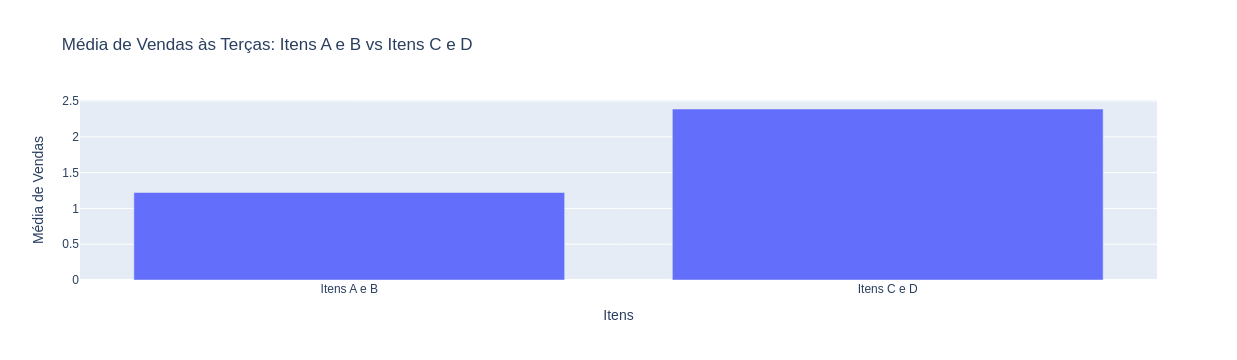


A média de vendas dos Itens A e B é 48.84% menor às terças-feiras em comparação com os Itens C e D.

A diferença na média de vendas dos Itens A e B às terças-feiras em comparação com os Itens C e D não é estatisticamente relevante.
Valor p: 0.08168613769921745


In [169]:
# Média de vendas dos itens A e B às terças-feiras
media_terca_itens_ab = df4[df4['dia_da_semana'] == 'terca'][['item_a', 'item_b']].mean().mean()

# Média de vendas dos itens C e D às terças-feiras
media_terca_itens_cd = df4[df4['dia_da_semana'] == 'terca'][['item_c', 'item_d']].mean().mean()

# Criação do DataFrame para o gráfico de barras
data = {
    'Itens': ['Itens A e B', 'Itens C e D'],
    'Média de Vendas às Terças': [media_terca_itens_ab, media_terca_itens_cd]
}
df_bar = pd.DataFrame(data)

# Plot do gráfico de barras
fig_bar = px.bar(df_bar, x='Itens', y='Média de Vendas às Terças', 
                 labels={'Média de Vendas às Terças': 'Média de Vendas', 'Itens': 'Itens'},
                 title='Média de Vendas às Terças: Itens A e B vs Itens C e D')

# Exibir o gráfico de barras
fig_bar.show()

# Cálculo da diferença percentual
diferenca_percentual = ((media_terca_itens_cd - media_terca_itens_ab) / media_terca_itens_cd) * 100

# Imprimindo a diferença percentual
print(f"\nA média de vendas dos Itens A e B é {diferenca_percentual:.2f}% menor às terças-feiras em comparação com os Itens C e D."'\n')

# Realizando o teste t
terca_itens_ab = df4[df4['dia_da_semana'] == 'terca'][['item_a', 'item_b']].values.flatten()
terca_itens_cd = df4[df4['dia_da_semana'] == 'terca'][['item_c', 'item_d']].values.flatten()

t_statistic, p_value = stats.ttest_ind(terca_itens_ab, terca_itens_cd)

alpha = 0.05

if p_value < alpha:
    print("A diferença na média de vendas dos Itens A e B às terças-feiras em comparação com os Itens C e D é estatisticamente relevante.")
else:
    print("A diferença na média de vendas dos Itens A e B às terças-feiras em comparação com os Itens C e D não é estatisticamente relevante.")

print("Valor p:", p_value)

#### <u>**Às sextas, os item a e c vendem 50% menos do que os itens b e d**<u/>

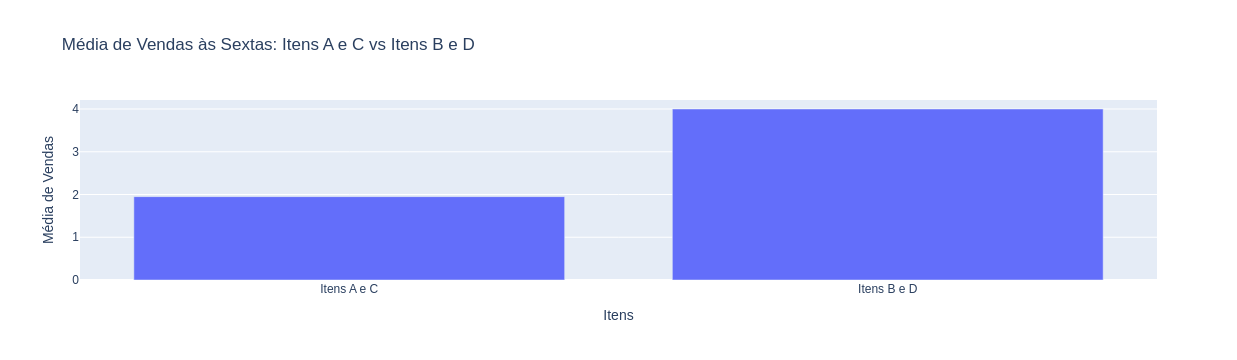


A média de vendas dos Itens A e C é 51.25% menor às sextas-feiras em comparação com os Itens B e D.

A diferença na média de vendas dos Itens A e C às sextas-feiras em comparação com os Itens B e D é estatisticamente relevante.
Valor p: 0.015568372281922123


In [170]:
# Média de vendas dos itens A e C às sextas-feiras
media_sexta_itens_ac = df4[df4['dia_da_semana'] == 'sexta'][['item_a', 'item_c']].mean().mean()

# Média de vendas dos itens B e D às sextas-feiras
media_sexta_itens_bd = df4[df4['dia_da_semana'] == 'sexta'][['item_b', 'item_d']].mean().mean()

# Criação do DataFrame para o gráfico de barras
data = {
    'Itens': ['Itens A e C', 'Itens B e D'],
    'Média de Vendas às Sextas': [media_sexta_itens_ac, media_sexta_itens_bd]
}
df_bar = pd.DataFrame(data)

# Plot do gráfico de barras
fig_bar = px.bar(df_bar, x='Itens', y='Média de Vendas às Sextas', 
                 labels={'Média de Vendas às Sextas': 'Média de Vendas', 'Itens': 'Itens'},
                 title='Média de Vendas às Sextas: Itens A e C vs Itens B e D')

# Exibir o gráfico de barras
fig_bar.show()

# Cálculo da diferença percentual
diferenca_percentual = ((media_sexta_itens_bd - media_sexta_itens_ac) / media_sexta_itens_bd) * 100

# Imprimindo a diferença percentual
print(f"\nA média de vendas dos Itens A e C é {diferenca_percentual:.2f}% menor às sextas-feiras em comparação com os Itens B e D."'\n')

# Realizando o teste t
sexta_itens_ac = df4[df4['dia_da_semana'] == 'sexta'][['item_a', 'item_c']].values.flatten()
sexta_itens_bd = df4[df4['dia_da_semana'] == 'sexta'][['item_b', 'item_d']].values.flatten()

t_statistic, p_value = stats.ttest_ind(sexta_itens_ac, sexta_itens_bd)

alpha = 0.05

if p_value < alpha:
    print("A diferença na média de vendas dos Itens A e C às sextas-feiras em comparação com os Itens B e D é estatisticamente relevante.")
else:
    print("A diferença na média de vendas dos Itens A e C às sextas-feiras em comparação com os Itens B e D não é estatisticamente relevante.")

print("Valor p:", p_value)

#### **O item b vende 20% a menos segunda e quinta do que terça e quarta**

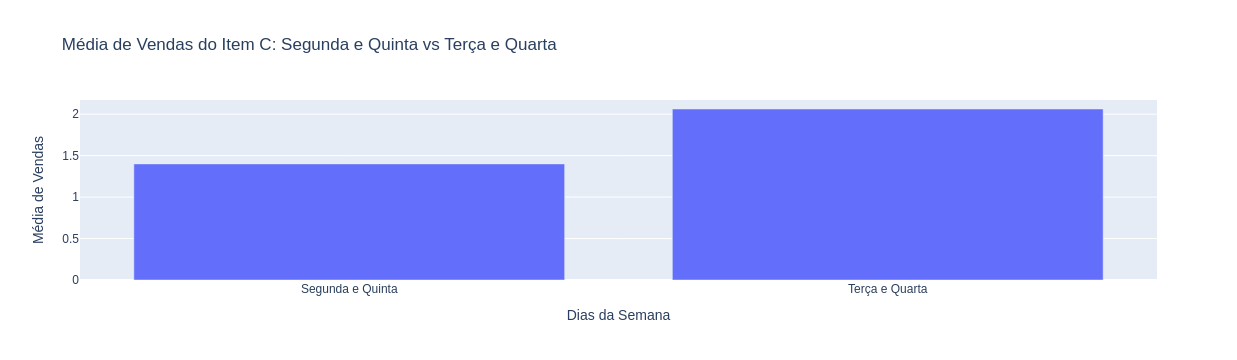


A média de vendas do Item C é 47.32% maior às terças e quartas-feiras em comparação com segundas e quintas-feiras.

A diferença na média de vendas do Item C entre segundas e quintas-feiras e terças e quartas-feiras não é estatisticamente relevante.
Valor p: 0.34854639118064823


In [171]:
# Média de vendas do item C às segundas e quintas-feiras
media_segunda_quinta_item_c = df4[df4['dia_da_semana'].isin(['segunda', 'quinta'])]['item_c'].mean()

# Média de vendas do item C às terças e quartas-feiras
media_terca_quarta_item_c = df4[df4['dia_da_semana'].isin(['terca', 'quarta'])]['item_c'].mean()

# Criação do DataFrame para o gráfico de barras
data = {
    'Dias da Semana': ['Segunda e Quinta', 'Terça e Quarta'],
    'Média de Vendas do Item C': [media_segunda_quinta_item_c, media_terca_quarta_item_c]
}
df_bar = pd.DataFrame(data)

# Plot do gráfico de barras
fig_bar = px.bar(df_bar, x='Dias da Semana', y='Média de Vendas do Item C', 
                 labels={'Média de Vendas do Item C': 'Média de Vendas', 'Dias da Semana': 'Dias da Semana'},
                 title='Média de Vendas do Item C: Segunda e Quinta vs Terça e Quarta')

# Exibir o gráfico de barras
fig_bar.show()

# Cálculo da diferença percentual
diferenca_percentual = ((media_terca_quarta_item_c - media_segunda_quinta_item_c) / media_segunda_quinta_item_c) * 100

# Imprimindo a diferença percentual
print(f"\nA média de vendas do Item C é {diferenca_percentual:.2f}% maior às terças e quartas-feiras em comparação com segundas e quintas-feiras."'\n')

# Realizando o teste t
segunda_quinta_item_c = df4[df4['dia_da_semana'].isin(['segunda', 'quinta'])]['item_c']
terca_quarta_item_c = df4[df4['dia_da_semana'].isin(['terca', 'quarta'])]['item_c']

t_statistic, p_value = stats.ttest_ind(segunda_quinta_item_c, terca_quarta_item_c)

alpha = 0.05

if p_value < alpha:
    print("A diferença na média de vendas do Item C entre segundas e quintas-feiras e terças e quartas-feiras é estatisticamente relevante.")
else:
    print("A diferença na média de vendas do Item C entre segundas e quintas-feiras e terças e quartas-feiras não é estatisticamente relevante.")

print("Valor p:", p_value)

#### **O item d vende 30% a mais às sextas, comparando com sábado e domingo**

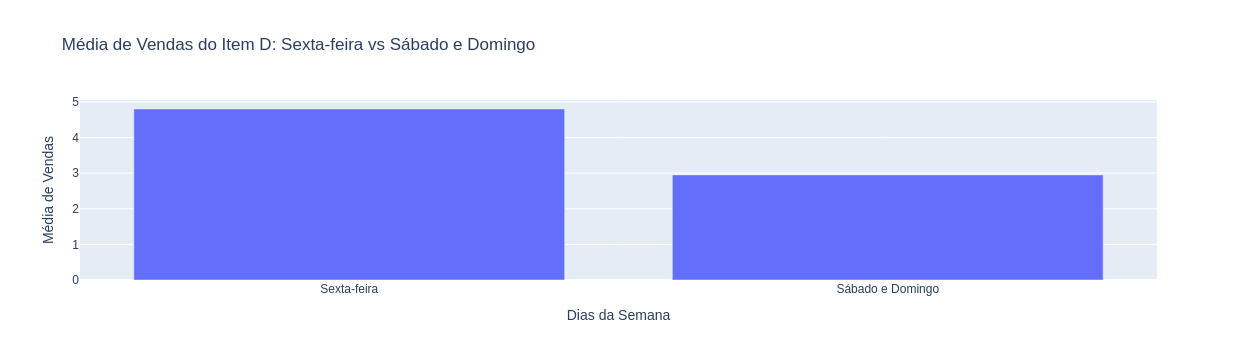


A média de vendas do Item D é 62.71% maior às sextas-feiras em comparação com sábados e domingos.

A diferença na média de vendas do Item D entre sextas-feiras e sábados e domingos não é estatisticamente relevante.
Valor p: 0.09544080043087066


In [172]:
# Média de vendas do item D às sextas-feiras
media_sexta_item_d = df4[df4['dia_da_semana'] == 'sexta']['item_d'].mean()

# Média de vendas do item D aos sábados e domingos
media_sabado_domingo_item_d = df4[df4['dia_da_semana'].isin(['sabado', 'domingo'])]['item_d'].mean()

# Criação do DataFrame para o gráfico de barras
data = {
    'Dias da Semana': ['Sexta-feira', 'Sábado e Domingo'],
    'Média de Vendas do Item D': [media_sexta_item_d, media_sabado_domingo_item_d]
}
df_bar = pd.DataFrame(data)

# Plot do gráfico de barras
fig_bar = px.bar(df_bar, x='Dias da Semana', y='Média de Vendas do Item D', 
                 labels={'Média de Vendas do Item D': 'Média de Vendas', 'Dias da Semana': 'Dias da Semana'},
                 title='Média de Vendas do Item D: Sexta-feira vs Sábado e Domingo')

# Exibir o gráfico de barras
fig_bar.show()

# Cálculo da diferença percentual
diferenca_percentual = ((media_sexta_item_d - media_sabado_domingo_item_d) / media_sabado_domingo_item_d) * 100

# Imprimindo a diferença percentual
print(f"\nA média de vendas do Item D é {diferenca_percentual:.2f}% maior às sextas-feiras em comparação com sábados e domingos."'\n')

# Realizando o teste t
sexta_item_d = df4[df4['dia_da_semana'] == 'sexta']['item_d']
sabado_domingo_item_d = df4[df4['dia_da_semana'].isin(['sabado', 'domingo'])]['item_d']

t_statistic, p_value = stats.ttest_ind(sexta_item_d, sabado_domingo_item_d)

alpha = 0.05

if p_value < alpha:
    print("A diferença na média de vendas do Item D entre sextas-feiras e sábados e domingos é estatisticamente relevante.")
else:
    print("A diferença na média de vendas do Item D entre sextas-feiras e sábados e domingos não é estatisticamente relevante.")

print("Valor p:", p_value)

## **4.3 Análise multivariada**

In [173]:
num_attributes = df4.select_dtypes( include=['int64'] )
num_attributes.drop(columns='itens_totais',inplace=True)

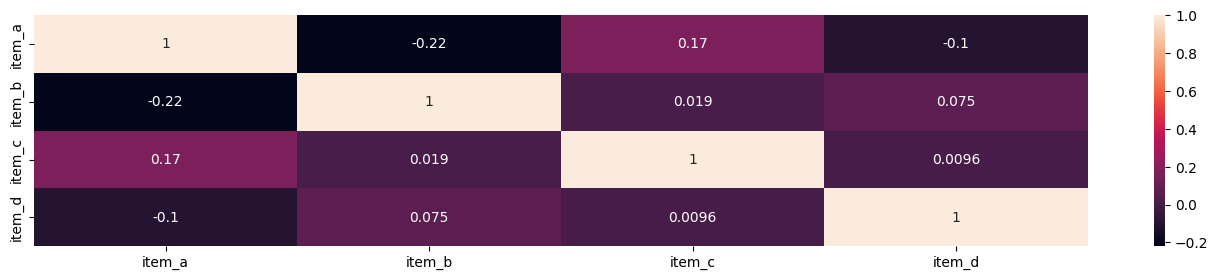

In [174]:
rcParams['figure.figsize'] = 17,3

correlation=num_attributes.corr(method='pearson')
sns.heatmap(correlation,annot=True);

## ***Principais insights***

- Segunda tem em média 45% menos vendas do que os outros dias úteis
- Sexta vende-se em média 55% a mais do que os outros dias úteis
- Entre sexta a domingo vende-se em média 82% a mais
- Entre sábado a domingo vende-se em média 72% a mais
- Às quintas o item B vende em média 63% menos do que os outros itens
- Às sextas os itens A e C vendem em média 51% menos do que os outros itens
- O tempo transcorrido na tabela é muito pequeno para observar tendências importantes
- Não existe uma relação aparente entre os itens

# **5 Preparação dos dados**

In [128]:
df5=df4.copy()

## **5.1 Encoders**

In [129]:
cols = ['dia_da_semana', 'tipo_dia', 'semana_do_mes']

enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

train_enc = enc.fit_transform(X_train_full[cols])
val_enc = enc.transform(X_val_full[cols])
test_enc = enc.transform(X_test_full[cols])

names = enc.get_feature_names_out(cols)

X_train= pd.DataFrame(train_enc, columns=names)
X_val= pd.DataFrame(val_enc, columns=names)
X_test = pd.DataFrame(test_enc, columns=names)

# **6 Seleção de features**

In [130]:
df6=df5.copy() 

In [131]:
final_cols=['dia_da_semana_segunda','dia_da_semana_sexta','dia_da_semana_sabado','dia_da_semana_domingo']

X_train=X_train[final_cols]
X_val=X_val[final_cols]
X_test=X_test[final_cols]

In [132]:
X_train_ts=X_train[final_cols]
X_val_ts=X_val[final_cols]
X_test_ts=X_test[final_cols]

X_train_ts[['item_a','item_b','item_c','item_d']]=y_train[['item_a','item_b','item_c','item_d']]
X_val_ts[['item_a','item_b','item_c','item_d']]=y_val[['item_a','item_b','item_c','item_d']]
X_test_ts[['item_a','item_b','item_c','item_d']]=y_test[['item_a','item_b','item_c','item_d']]

X_train_ts.loc[:,'data'] = X_train_full['data']
X_val_ts.loc[:,'data'] = X_val_full['data']
X_test_ts.loc[:,'data'] = X_test_full['data']

X_train_ts.set_index('data', inplace=True)
X_val_ts.set_index('data', inplace=True)
X_test_ts.set_index('data', inplace=True)

X_train_ts.index = pd.DatetimeIndex(X_train_ts.index).to_period('D')
X_val_ts.index = pd.DatetimeIndex(X_val_ts.index).to_period('D')
X_test_ts.index = pd.DatetimeIndex(X_test_ts.index).to_period('D')

X_train_ts=pd.concat([X_train_ts,X_val_ts])

# **7 Machine learning**

In [133]:
df4.head()

,data,item_a,item_b,item_c,item_d,itens_totais,dia_da_semana,dia,tipo_dia,semana_do_mes,itens_totais_mm,item_a_mm,item_b_mm,item_c_mm,item_d_mm
0,2021-06-01,3,0,4,0,7,terca,1,util,primeira,NaN,NaN,NaN,NaN,NaN
1,2021-06-04,0,6,3,1,10,sexta,4,util,primeira,NaN,NaN,NaN,NaN,NaN
2,2021-06-05,5,3,0,1,9,sabado,5,fds,primeira,NaN,NaN,NaN,NaN,NaN
3,2021-06-06,0,8,4,0,12,domingo,6,fds,primeira,NaN,NaN,NaN,NaN,NaN
4,2021-06-07,2,1,0,0,3,segunda,7,util,primeira,NaN,NaN,NaN,NaN,NaN


In [134]:
df7=df6.copy()

## **Modelo baseline**

In [135]:
mean_item_a = df7['item_a'].mean()
mean_item_b = df7['item_b'].mean()
mean_item_c = df7['item_c'].mean()
mean_item_d = df7['item_d'].mean()

y_pred = pd.DataFrame({
    'item_a': [mean_item_a] * len(y_test),
    'item_b': [mean_item_b] * len(y_test),
    'item_c': [mean_item_c] * len(y_test),
    'item_d': [mean_item_d] * len(y_test)})

mae_item_a = mean_absolute_error(y_test['item_a'], y_pred['item_a'])
mae_item_b = mean_absolute_error(y_test['item_b'], y_pred['item_b'])
mae_item_c = mean_absolute_error(y_test['item_c'], y_pred['item_c'])
mae_item_d = mean_absolute_error(y_test['item_d'], y_pred['item_d'])

mae_geral = (mae_item_a + mae_item_b + mae_item_c + mae_item_d) / 4

print("MAE geral:", mae_geral)
print("MAE Item a:", mae_item_a)
print("MAE Item b:", mae_item_b)
print("MAE Item c:", mae_item_c)
print("MAE Item d:", mae_item_d)

MAE geral: 2.0153688524590163
MAE Item a: 1.9106557377049178
MAE Item b: 1.960655737704918
MAE Item c: 1.95
MAE Item d: 2.2401639344262296


## **Regressão linear**

In [136]:
reg = MultiOutputRegressor(DecisionTreeRegressor()).fit(X_train, y_train)

reg_pred = reg.predict(X_test)

reg_mae = mean_absolute_error(y_test, reg_pred)
a_reg_mae = mean_absolute_error(y_test['item_a'], reg_pred[:, 0])
b_reg_mae = mean_absolute_error(y_test['item_b'], reg_pred[:, 1])
c_reg_mae = mean_absolute_error(y_test['item_c'], reg_pred[:, 2])
d_reg_mae = mean_absolute_error(y_test['item_d'], reg_pred[:, 3])

print("Regression - MAE geral: ", reg_mae)
print("Regression - MAE Item A: ", a_reg_mae)
print("Regression - MAE Item B: ", b_reg_mae)
print("Regression - MAE Item C: ", c_reg_mae)
print("Regression - MAE Item D: ", d_reg_mae)

Regression - MAE geral:  2.020654761904762
Regression - MAE Item A:  1.9133333333333333
Regression - MAE Item B:  2.1723809523809523
Regression - MAE Item C:  1.818333333333333
Regression - MAE Item D:  2.178571428571429


## **Árvores**

In [137]:
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
forest_model.fit(X_train, y_train)

tree_pred = tree_model.predict(X_test)
forest_pred = forest_model.predict(X_test)
 
tree_mae = mean_absolute_error(y_test, tree_pred)
a_tree_mae = mean_absolute_error(y_test['item_a'], tree_pred[:, 0])
b_tree_mae = mean_absolute_error(y_test['item_b'], tree_pred[:, 1])
c_tree_mae = mean_absolute_error(y_test['item_c'], tree_pred[:, 2])
d_tree_mae = mean_absolute_error(y_test['item_d'], tree_pred[:, 3])

forest_mae = mean_absolute_error(y_test, forest_pred)
a_forest_mae = mean_absolute_error(y_test['item_a'], forest_pred[:, 0])
b_forest_mae = mean_absolute_error(y_test['item_b'], forest_pred[:, 1])
c_forest_mae = mean_absolute_error(y_test['item_c'], forest_pred[:, 2])
d_forest_mae = mean_absolute_error(y_test['item_d'], forest_pred[:, 3])

print("Decision Tree - MAE geral: ", tree_mae)
print("Decision Tree - MAE Item a: ", a_tree_mae)
print("Decision Tree - MAE Item b: ", b_tree_mae)
print("Decision Tree - MAE Item c: ", c_tree_mae)
print("Decision Tree - MAE Item d: ", d_tree_mae)

print('\n'"Random Forest Model - MAE geral: ", forest_mae)
print("Random Forest - MAE Item a: ", a_forest_mae)
print("Random Forest - MAE Item b: ", b_forest_mae)
print("Random Forest - MAE Item c: ", c_forest_mae)
print("Random Forest - MAE Item d: ", d_forest_mae)

Decision Tree - MAE geral:  2.020654761904762
Decision Tree - MAE Item a:  1.9133333333333333
Decision Tree - MAE Item b:  2.1723809523809523
Decision Tree - MAE Item c:  1.818333333333333
Decision Tree - MAE Item d:  2.178571428571429

Random Forest Model - MAE geral:  2.0351986612136574
Random Forest - MAE Item a:  1.9186771412969557
Random Forest - MAE Item b:  2.157171164280336
Random Forest - MAE Item c:  1.8319183811243795
Random Forest - MAE Item d:  2.233027958152958


## **Time series**

In [138]:
model = VAR(X_train_ts)
model_fit = model.fit()

pred = model_fit.forecast(X_train_ts.values, steps=len(X_test_ts))

pred_df = pd.DataFrame(pred, index=X_test_ts.index, columns=X_train_ts.columns)

mae_a = mean_absolute_error(X_test_ts['item_a'], pred_df['item_a'])
mae_b = mean_absolute_error(X_test_ts['item_b'], pred_df['item_b'])
mae_c = mean_absolute_error(X_test_ts['item_c'], pred_df['item_c'])
mae_d = mean_absolute_error(X_test_ts['item_d'], pred_df['item_d'])
mae_geral = (mae_a + mae_b + mae_c + mae_d) / 4

print(f'Time series - MAE Geral: {mae_geral}')
print(f'Time series - MAE Item a: {mae_a}')
print(f'Time series - MAE Item b: {mae_b}')
print(f'Time series - MAE Item c: {mae_c}')
print(f'Time series - MAE Item d: {mae_d}')

Time series - MAE Geral: 2.050536707593216
Time series - MAE Item a: 1.860599191367913
Time series - MAE Item b: 2.0466706564303117
Time series - MAE Item c: 1.9924104729177567
Time series - MAE Item d: 2.3024665096568837


# **Conclusões finais**

In [140]:
print('done')

done
